# Introduction

[Insideairbnb.com](https://www.insideairbnb.com/) is a website where datasets are published that are extracted from "snapshots" of cities' websites. I have downloaded the files for Berlin up to 10/27/2023. I thought it would be a fun dataset to work with. In addition to basic data scraping and plots, I have also added **interactive Folium maps, interactive plot graphs, and text extraction from review comments.**

![Berlin Image](https://www.laguiadeberlin.com/wp-content/uploads/2017/09/berlin-airbnb.jpg)

# 1. Importing Modules and Data


In [1]:
!pip install geopandas
!pip install chart_studio
!pip install plotly

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import math

import os
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px 
import sklearn
from sklearn import datasets

# mapas interactivos
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap

#to make the plotly graphs
import plotly.graph_objs as go
import chart_studio.plotly as py
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
import plotly.express as px
import matplotlib.pyplot as plt

#text mining
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud

In [3]:
print(os.listdir('data'))

['calendar.csv.gz', 'listings.csv', 'listings.csv.gz', 'neighbourhoods.csv', 'neighbourhoods.geojson', 'reviews.csv', 'reviews.csv.gz']


In [4]:
calendar = pd.read_csv('data/calendar.csv.gz',parse_dates = ['date'],index_col=['listing_id'])
listings = pd.read_csv('data/listings.csv',index_col='id')
listings_details = pd.read_csv('data/listings.csv.gz',index_col='id')
neighbourhoods = pd.read_csv('data/neighbourhoods.csv')
reviews = pd.read_csv('data/reviews.csv',parse_dates=['date'])
reviews_details = pd.read_csv('data/reviews.csv.gz',parse_dates=['date'])

# <p align="center">PREPROCESSING</p>

### We start by examining the number of null values in each dataset

In [5]:
calendar.isnull().sum()/len(calendar)*100

date              0.0
available         0.0
price             0.0
adjusted_price    0.0
minimum_nights    0.0
maximum_nights    0.0
dtype: float64

In [6]:
listings.isnull().sum()/len(listings)*100

name                               0.000000
host_id                            0.000000
host_name                          0.068524
neighbourhood_group                0.000000
neighbourhood                      0.000000
latitude                           0.000000
longitude                          0.000000
room_type                          0.000000
price                              0.000000
minimum_nights                     0.000000
number_of_reviews                  0.000000
last_review                       20.983706
reviews_per_month                 20.983706
calculated_host_listings_count     0.000000
availability_365                   0.000000
number_of_reviews_ltm              0.000000
license                           38.998020
dtype: float64

In [7]:
listings_details.isnull().sum()/len(listings_details)*100

listing_url                                      0.000000
scrape_id                                        0.000000
last_scraped                                     0.000000
source                                           0.000000
name                                             0.000000
                                                  ...    
calculated_host_listings_count                   0.000000
calculated_host_listings_count_entire_homes      0.000000
calculated_host_listings_count_private_rooms     0.000000
calculated_host_listings_count_shared_rooms      0.000000
reviews_per_month                               20.983706
Length: 74, dtype: float64

In [8]:
neighbourhoods.isnull().sum()/len(neighbourhoods)*100

neighbourhood_group    0.719424
neighbourhood          0.719424
dtype: float64

In [9]:
reviews.isnull().sum()/len(reviews)*100

listing_id    0.0
date          0.0
dtype: float64

In [10]:
reviews_details.isnull().sum()/len(reviews_details)*100

listing_id       0.000000
id               0.000000
date             0.000000
reviewer_id      0.000000
reviewer_name    0.000000
comments         0.006687
dtype: float64

In [11]:
listings_details.columns

Index(['listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar

### We proceed to remove columns with more than 30% of null data (except for host_response_time and host_response_rate, as we will use them later)


In [12]:
def remove_nulls(df: pd.DataFrame, threshold: float = 0.3) -> pd.DataFrame:
    columns_to_exclude = ['host_response_time', 'host_response_rate']
    cols_to_drop = df.columns[df.isnull().mean() > threshold]
    cols_to_drop = [col for col in cols_to_drop if col not in columns_to_exclude]
    df = df.drop(columns=cols_to_drop)
    return df

In [13]:
calendar = remove_nulls(calendar)
listings = remove_nulls(listings)
listings_details = remove_nulls(listings_details)
neighbourhoods = remove_nulls(neighbourhoods)
reviews = remove_nulls(reviews)
reviews_details = remove_nulls(reviews_details)

In [14]:
listings_details.columns

Index(['listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'picture_url', 'host_id', 'host_url', 'host_name',
       'host_since', 'host_location', 'host_response_time',
       'host_response_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms_text', 'beds', 'amenities', 'price', 'minimum_nights',
       'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped', 'number_of_reviews',


In [15]:
target_columns = ["property_type", "accommodates", "first_review", "review_scores_value", "review_scores_cleanliness", "review_scores_location", "review_scores_accuracy", "review_scores_communication", "review_scores_checkin", "review_scores_rating", "maximum_nights", "listing_url", "host_is_superhost", "host_response_time", "host_response_rate"]
listings = pd.merge(listings, listings_details[target_columns], on='id', how='left')
listings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13134 entries, 3176 to 981159693242362351
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            13134 non-null  object 
 1   host_id                         13134 non-null  int64  
 2   host_name                       13125 non-null  object 
 3   neighbourhood_group             13134 non-null  object 
 4   neighbourhood                   13134 non-null  object 
 5   latitude                        13134 non-null  float64
 6   longitude                       13134 non-null  float64
 7   room_type                       13134 non-null  object 
 8   price                           13134 non-null  int64  
 9   minimum_nights                  13134 non-null  int64  
 10  number_of_reviews               13134 non-null  int64  
 11  last_review                     10378 non-null  object 
 12  reviews_per_month    

### Missing values are filled with the mean, mode, or median depending on the variable type

In [16]:
def replace_missing_data(df):
# Vemos qué columnas tienen valores nulos
    mis_cols = list(df.isnull().sum(axis=0)[df.isnull().sum(axis=0)>0].index)
# Iteramos sobre ellas
    for col in mis_cols:
        # Si la variable es discreta,...
        if df[col].dtype in ['object']:
            mode_col = df[col].mode().values[0]
            df[col] = df[col].fillna(mode_col)
        # Si son números enteros
        elif df[col].dtype in ['int']:
            df[col] = df[col].fillna(df[col].median())
        # Si son números reales
        elif df[col].dtype in ['float']:
            df[col] = df[col].fillna(df[col].mean())
    # Devolvemos el DataFrame
    return df

In [17]:
listings = replace_missing_data(listings)

In [18]:
listings.columns

Index(['name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'property_type', 'accommodates',
       'first_review', 'review_scores_value', 'review_scores_cleanliness',
       'review_scores_location', 'review_scores_accuracy',
       'review_scores_communication', 'review_scores_checkin',
       'review_scores_rating', 'maximum_nights', 'listing_url',
       'host_is_superhost', 'host_response_time', 'host_response_rate'],
      dtype='object')

In [19]:
listings['neighbourhood_group'].unique()

array(['Pankow', 'Friedrichshain-Kreuzberg', 'Neukölln',
       'Charlottenburg-Wilm.', 'Tempelhof - Schöneberg', 'Mitte',
       'Treptow - Köpenick', 'Marzahn - Hellersdorf',
       'Steglitz - Zehlendorf', 'Spandau', 'Lichtenberg', 'Reinickendorf'],
      dtype=object)

In [20]:
listings.isnull().sum().sum()

0

### After confirming that there are no null values, we proceed to address the outliers

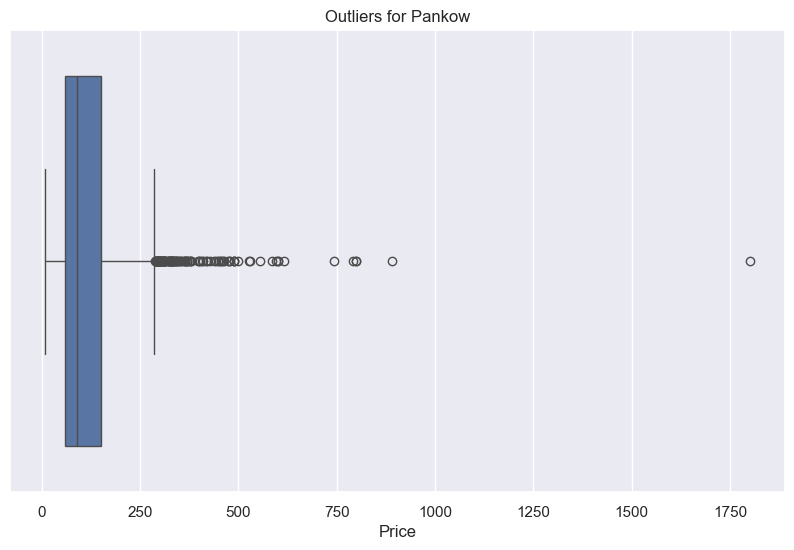

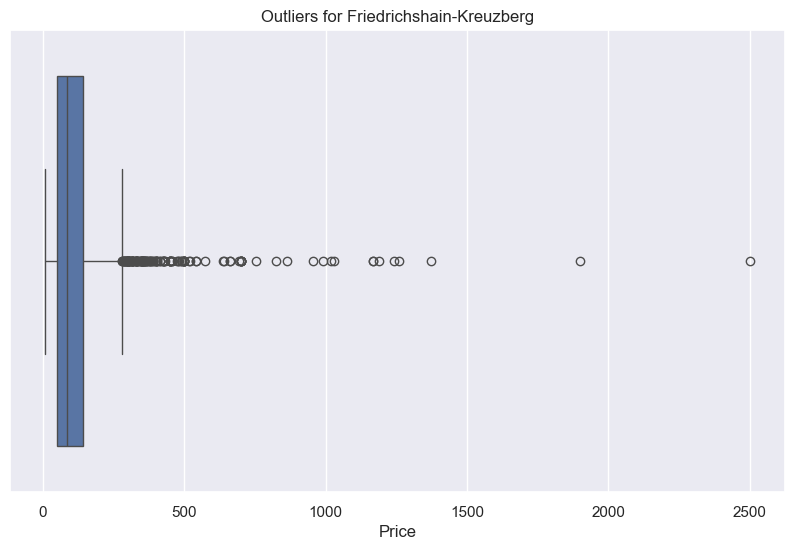

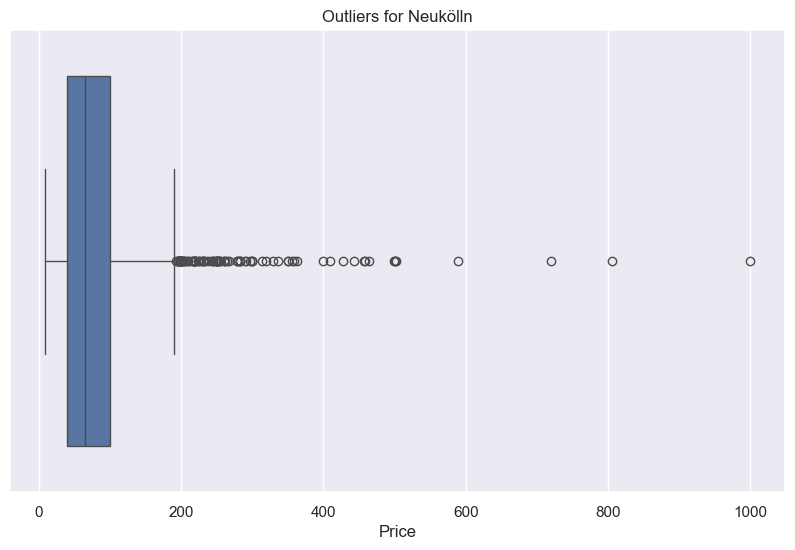

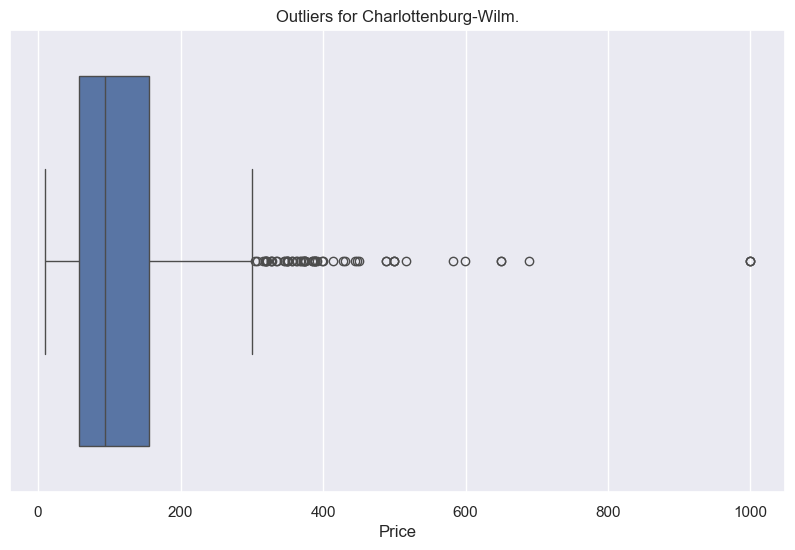

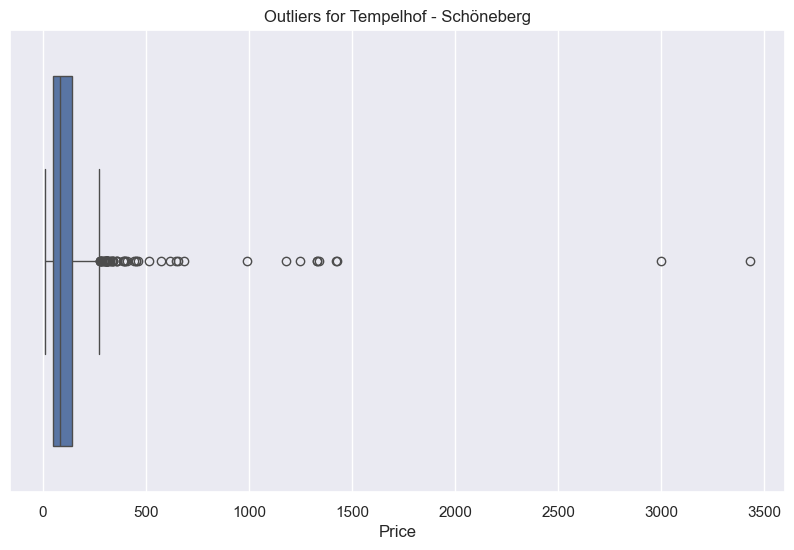

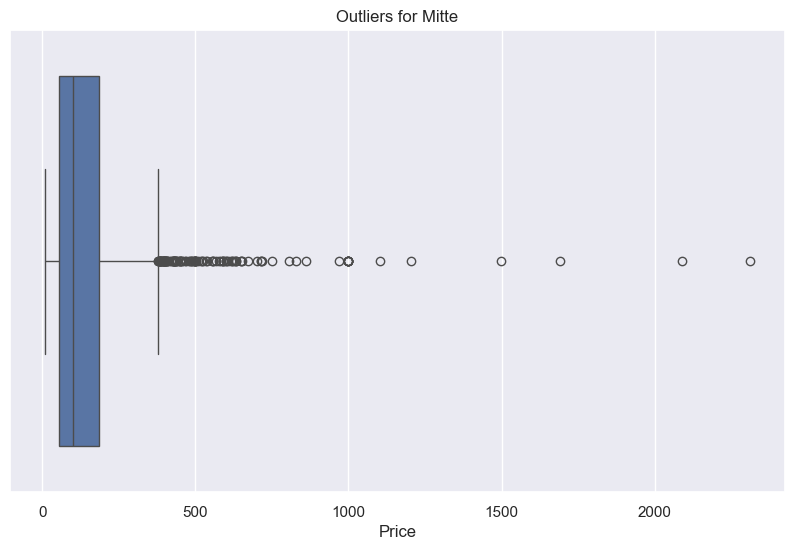

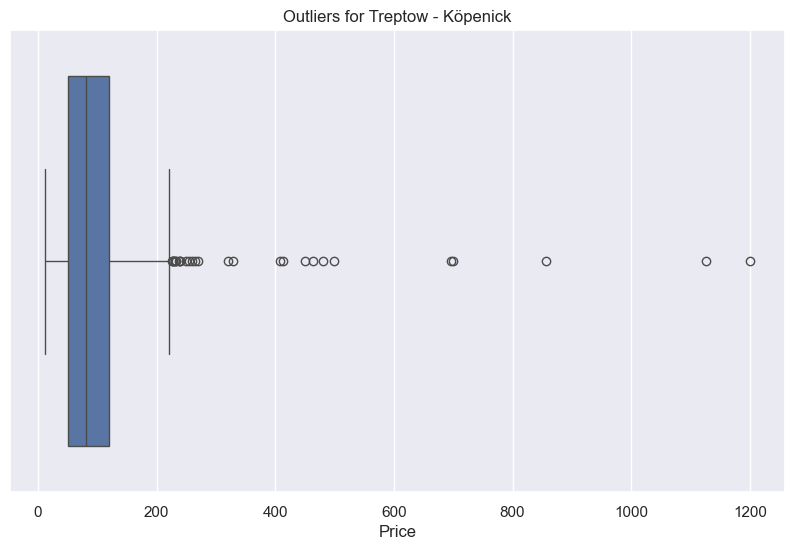

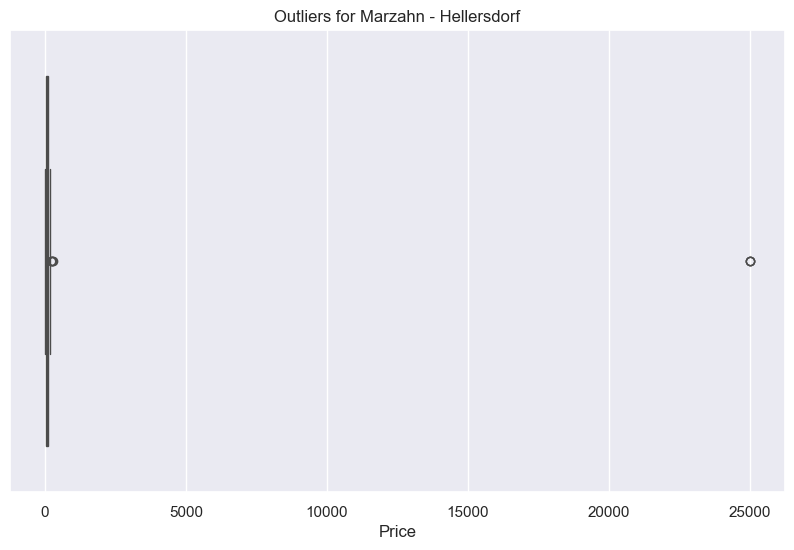

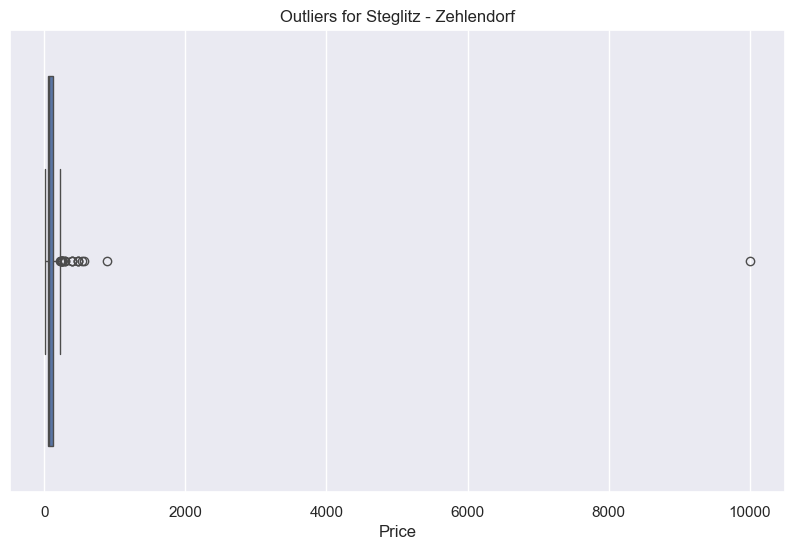

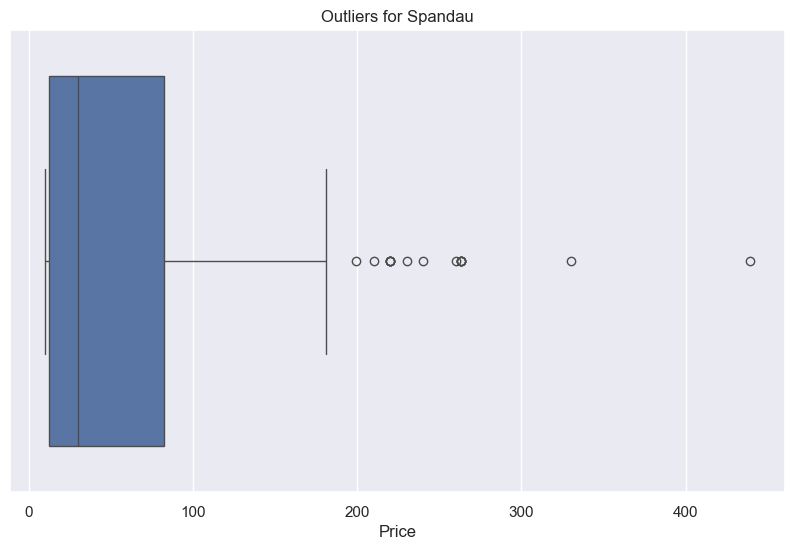

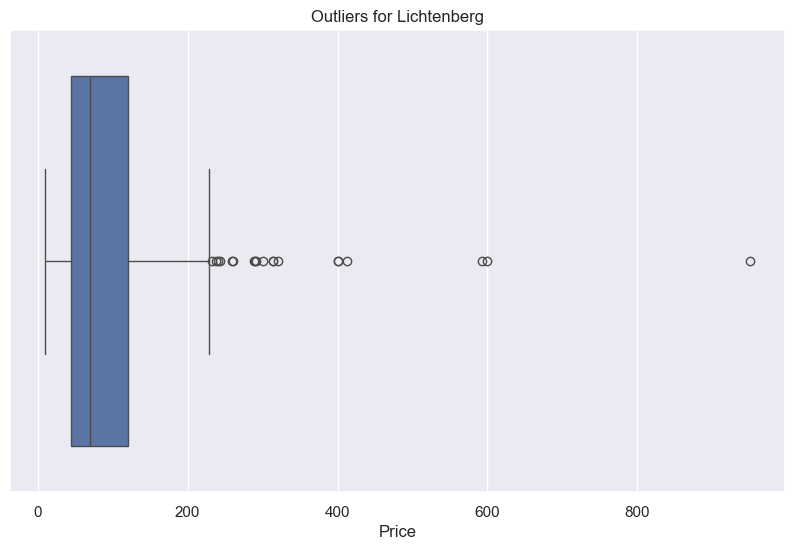

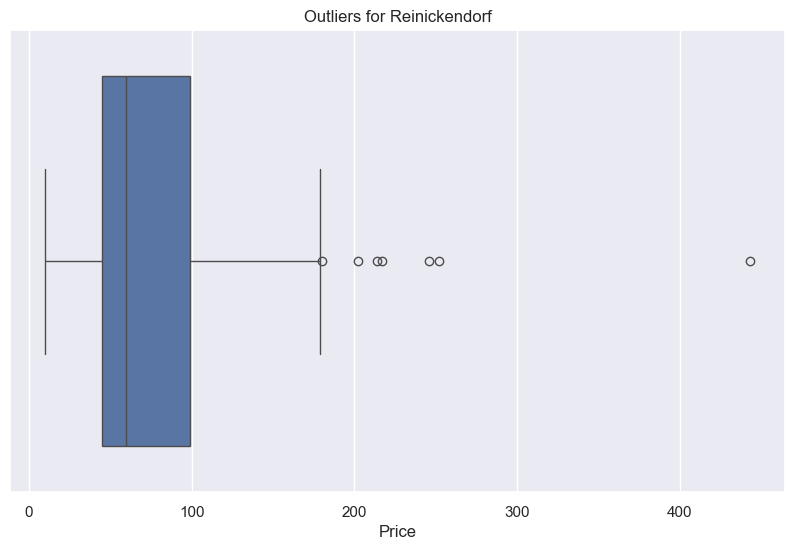

In [21]:
neighborhood_groups = listings['neighbourhood_group'].unique()

for neighborhood_group in neighborhood_groups:
    data = listings[listings['neighbourhood_group'] == neighborhood_group]
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='price', data=data)
    plt.title(f"Outliers for {neighborhood_group}")
    plt.xlabel("Price")
    plt.show()

In [22]:
neighborhood_groups = listings['neighbourhood_group'].unique()

def outliers_df(neigh_group):
    data = listings[listings['neighbourhood_group'] == neigh_group]
    
    Q1 = data['price'].quantile(0.25)
    Q3 = data['price'].quantile(0.75)
    IQR = Q3 - Q1
    outlierIzq = Q1 - 1.5 * IQR
    outlierDer = Q3 + 1.5 * IQR
    
    data['price'] = data['price'].clip(outlierIzq, outlierDer)
    
    return data

listings = pd.concat([outliers_df(neigh_group) for neigh_group in neighborhood_groups])

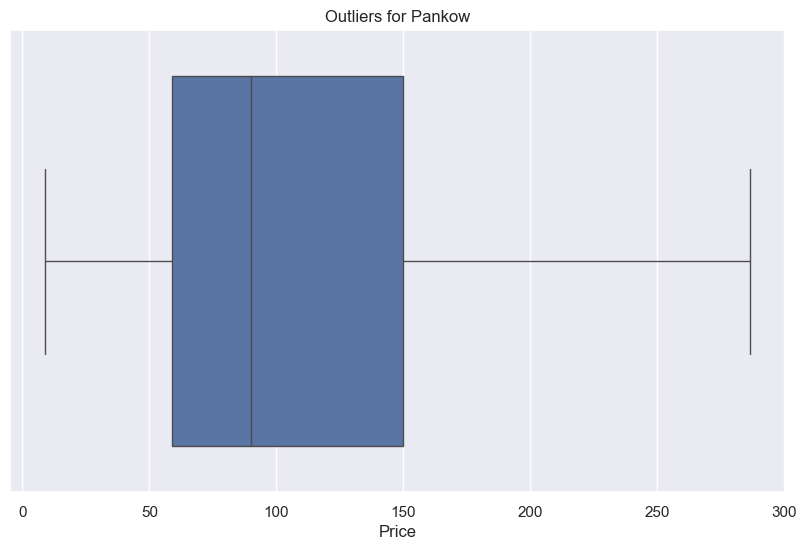

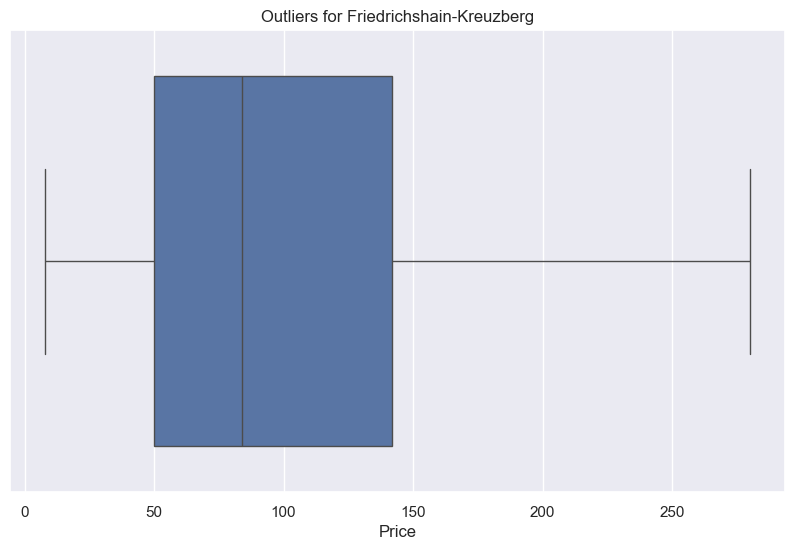

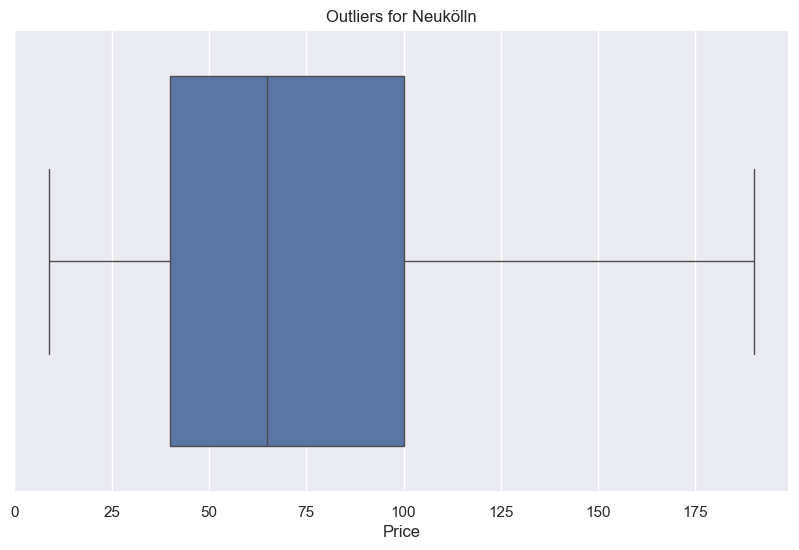

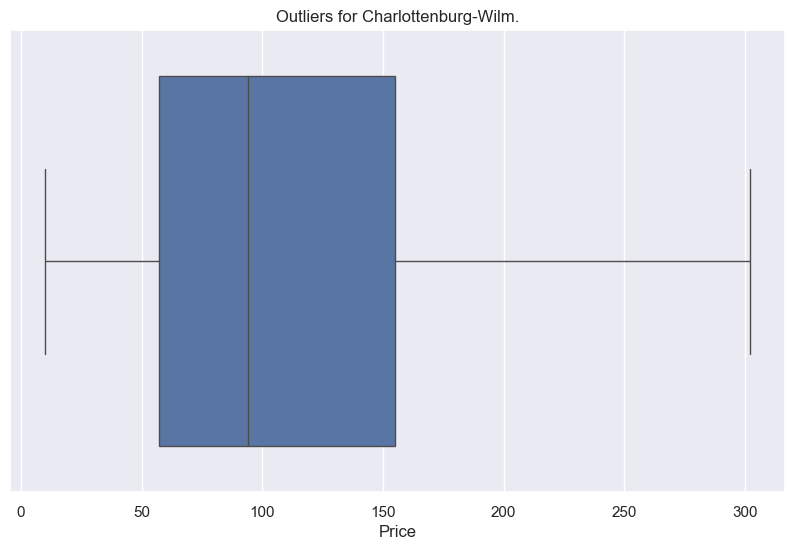

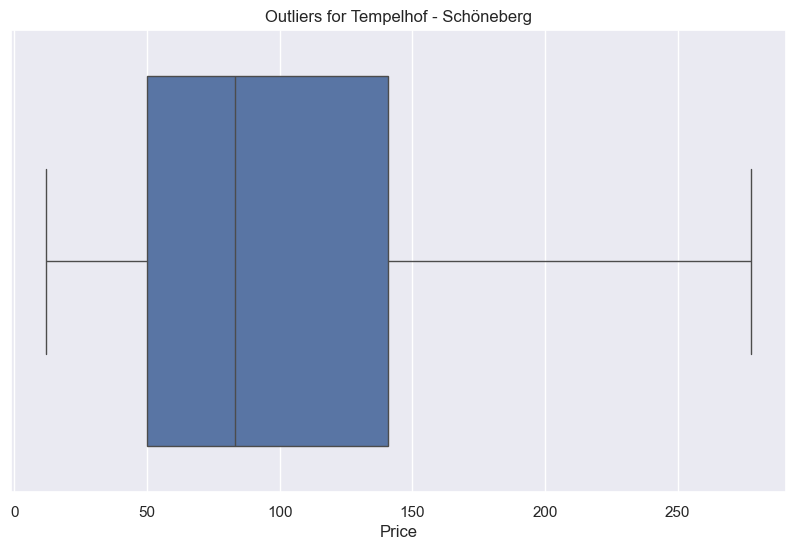

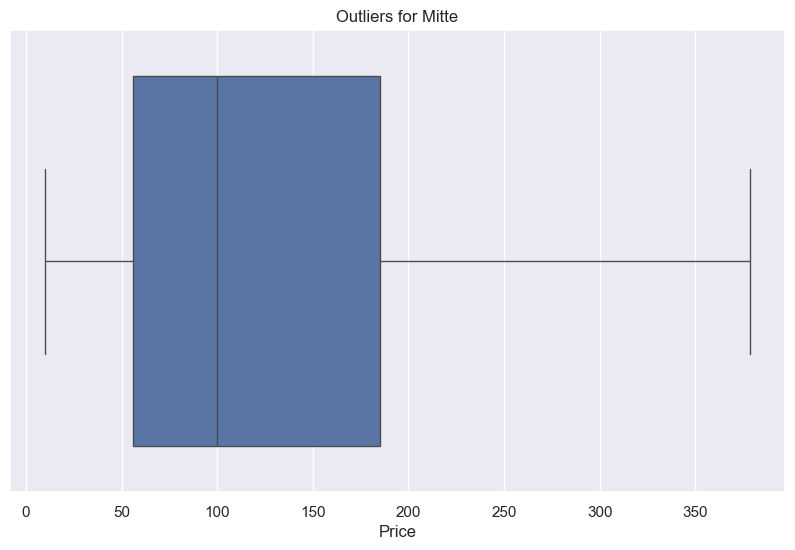

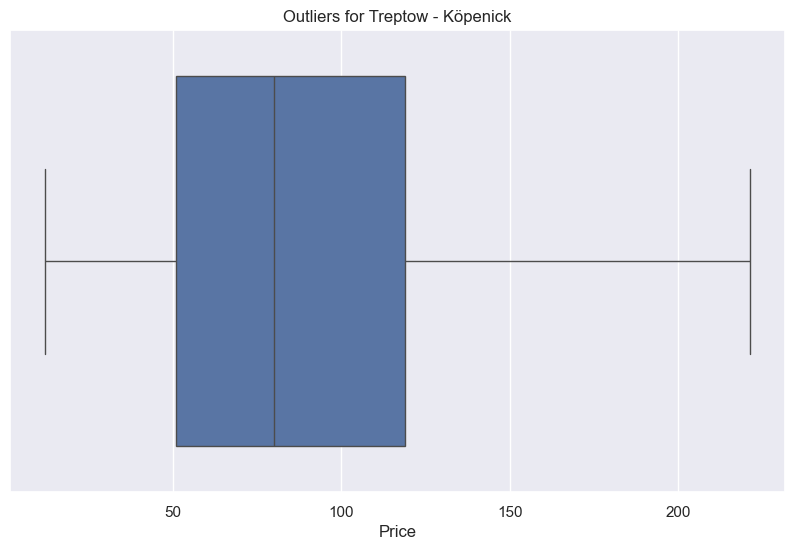

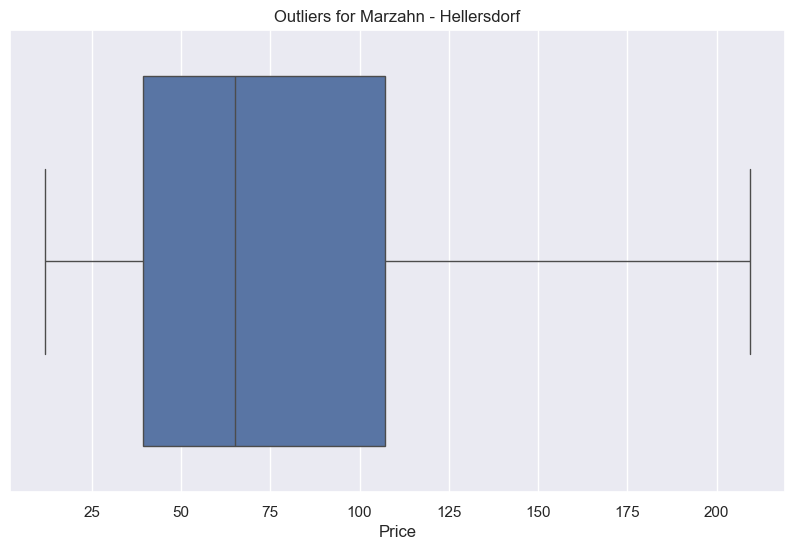

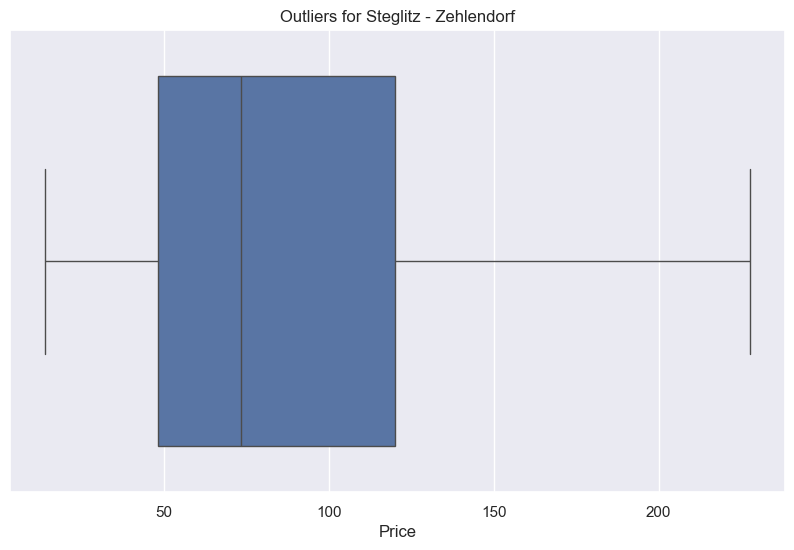

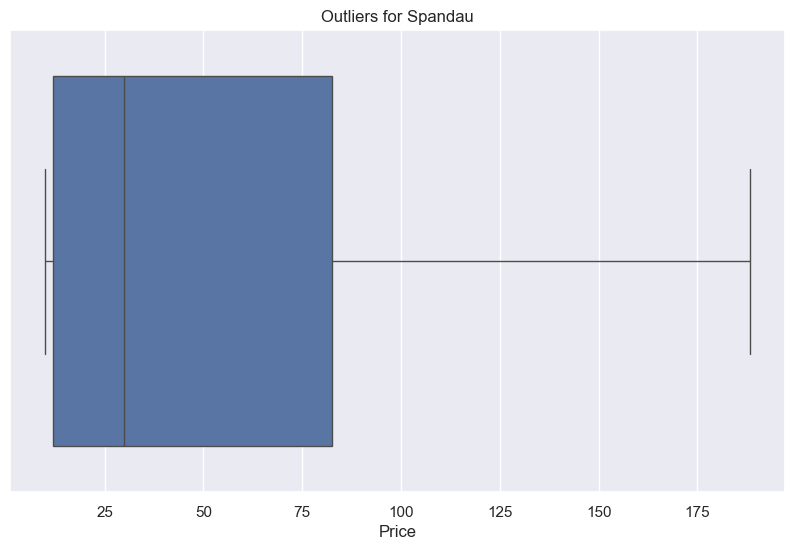

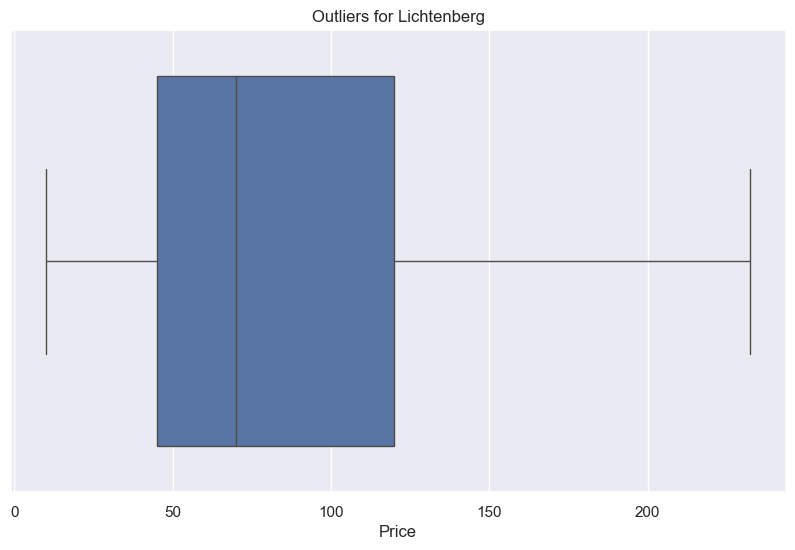

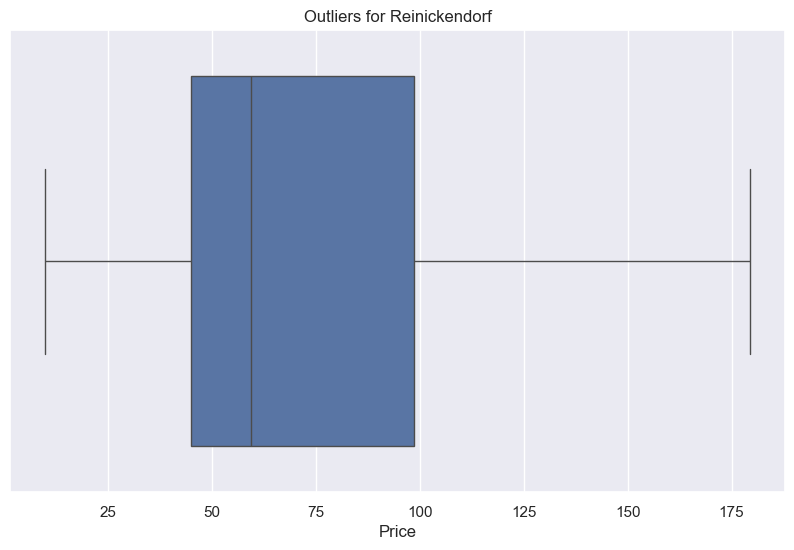

In [23]:
neighborhood_groups = listings['neighbourhood_group'].unique()

for neighborhood_group in neighborhood_groups:
    data = listings[listings['neighbourhood_group'] == neighborhood_group]
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='price', data=data)
    plt.title(f"Outliers for {neighborhood_group}")
    plt.xlabel("Price")
    plt.show()

### We now have the datasets prepared for performing the Exploratory Data Analysis (EDA)


# <CENTER>EDA

In [24]:
listings.columns

Index(['name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'property_type', 'accommodates',
       'first_review', 'review_scores_value', 'review_scores_cleanliness',
       'review_scores_location', 'review_scores_accuracy',
       'review_scores_communication', 'review_scores_checkin',
       'review_scores_rating', 'maximum_nights', 'listing_url',
       'host_is_superhost', 'host_response_time', 'host_response_rate'],
      dtype='object')

In [25]:
neighbourhoods.head()

neighbourhood_group        neighbourhood
0  Charlottenburg-Wilm.            Barstraße
1  Charlottenburg-Wilm.  Charlottenburg Nord
2  Charlottenburg-Wilm.  Düsseldorfer Straße
3  Charlottenburg-Wilm.      Forst Grunewald
4  Charlottenburg-Wilm.            Grunewald

In [26]:
neighbourhoods['neighbourhood_group'].unique()

array(['Charlottenburg-Wilm.', 'Friedrichshain-Kreuzberg', 'Lichtenberg',
       'Marzahn - Hellersdorf', 'Mitte', 'Neukölln', 'Pankow',
       'Reinickendorf', 'Spandau', 'Steglitz - Zehlendorf',
       'Tempelhof - Schöneberg', 'Treptow - Köpenick', nan], dtype=object)

In [27]:
BerNeigh =listings['neighbourhood_group'].value_counts().sort_values(ascending=True)
BerNeigh

neighbourhood_group
Marzahn - Hellersdorf        106
Reinickendorf                202
Spandau                      207
Steglitz - Zehlendorf        306
Lichtenberg                  345
Treptow - Köpenick           524
Tempelhof - Schöneberg       918
Charlottenburg-Wilm.        1209
Neukölln                    1555
Pankow                      2058
Mitte                       2833
Friedrichshain-Kreuzberg    2871
Name: count, dtype: int64

In [28]:
listings.head()

name  host_id  \
id                                                                  
3176   Rental unit in Berlin · ★4.63 · 1 bedroom · 2 ...     3718   
9991   Rental unit in Berlin · ★5.0 · 4 bedrooms · 7 ...    33852   
14325  Rental unit in Berlin · ★4.67 · Studio · 1 bed...    55531   
30295  Rental unit in Berlin · ★4.79 · 2 bedrooms · 4...   485838   
20858  Loft in Berlin · ★4.49 · 2 bedrooms · 2 beds ·...    71331   

            host_name neighbourhood_group             neighbourhood  latitude  \
id                                                                              
3176           Britta              Pankow   Prenzlauer Berg Südwest  52.53471   
9991          Philipp              Pankow   Prenzlauer Berg Südwest  52.53269   
14325  Chris + Oliver              Pankow  Prenzlauer Berg Nordwest  52.54813   
30295         Michele              Pankow            Helmholtzplatz  52.54596   
20858            Marc              Pankow   Prenzlauer Berg Südwest  52.53711   

       longitude        room_type  price  minimum_nights  ...  \
id                                                        ...   
3176    13.41810  Entire home/apt   83.0              63  ...   
9991    13.41805  Entire home/apt  180.0               6  ...   
14325   13.40366  Entire home/apt   70.0             150  ...   
30295   13.42291  Entire home/apt  126.0               4  ...   
20858   13.40888  Entire home/apt  179.0               3  ...   

       review_scores_location review_scores_accuracy  \
id                                                     
3176                     4.92                   4.67   
9991                     4.86                   5.00   
14325                    4.58                   5.00   
30295                    4.87                   4.82   
20858                    4.90                   4.60   

       review_scores_communication  review_scores_checkin  \
id                                                          
3176                          4.69                   4.64   
9991                          5.00                   5.00   
14325                         4.84                   4.68   
30295                         4.93                   4.91   
20858                         4.50                   4.50   

       review_scores_rating  maximum_nights  \
id                                            
3176                   4.63             184   
9991                   5.00              14   
14325                  4.67            1125   
30295                  4.79             365   
20858                  4.49              30   

                              listing_url  host_is_superhost  \
id                                                             
3176    https://www.airbnb.com/rooms/3176                  f   
9991    https://www.airbnb.com/rooms/9991                  f   
14325  https://www.airbnb.com/rooms/14325                  f   
30295  https://www.airbnb.com/rooms/30295                  t   
20858  https://www.airbnb.com/rooms/20858                  t   

       host_response_time  host_response_rate  
id                                             
3176       within an hour                100%  
9991       within an hour                100%  
14325  within a few hours                 86%  
30295      within an hour                 96%  
20858      within an hour                100%  

[5 rows x 31 columns]

## Neighborhoods with the Most Listings on the Platform


In [30]:
#Plotly version 
figNeigh = px.bar(BerNeigh, orientation='h', title="Number of listings by neighbourhood", template='plotly_dark')
figNeigh.update_yaxes(title_text='')
figNeigh.update_layout(showlegend=False)
figNeigh.update_traces(marker=dict(color="#FF9D4C"))  
figNeigh.show()

### Average Price by Neighborhood


In [31]:
price = listings.groupby('neighbourhood_group')['price'].mean().sort_values(ascending = False)
dfprice = pd.DataFrame(price)
dfprice = dfprice.reset_index()
#ahora graficamos con plotly
px.area(dfprice, x="neighbourhood_group", y="price",template= "plotly_dark", title = "Average daily price based on location in Berlin")


### Average Price by Neighborhood

In [33]:
latitudes = listings['latitude'].tolist()
longitudes = listings['longitude'].tolist()
locations = list(zip(latitudes, longitudes))

map1 = folium.Map(location=[52.516626523884305, 13.403950628235267], zoom_start=10.5)
FastMarkerCluster(data=locations).add_to(map1)
map1

### Types of Advertised Properties

In [34]:
room_type = listings['room_type']. value_counts().sort_values(ascending=True)
room_type

room_type
Hotel room          132
Shared room         262
Private room       4309
Entire home/apt    8431
Name: count, dtype: int64

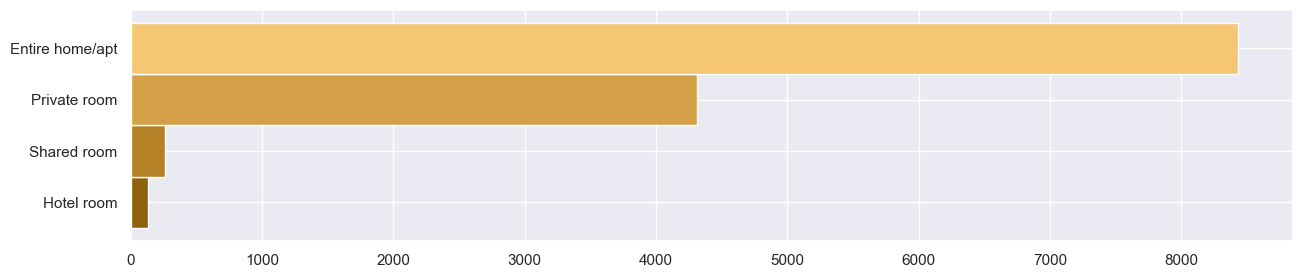

In [35]:
figRoomT = room_type.plot.barh(figsize=(15, 3), width=1, color=["#8F600D","#B58126", "#D3A047", "#F5C673"])
figRoomT.set_ylabel("")
plt.show()

In [37]:
prop = listings.groupby(['property_type','room_type']).room_type.count()
prop = prop.unstack()
prop.T

property_type    Boat  Bus  Camper/RV  Casa particular  Cave  Dome  \
room_type                                                            
Entire home/apt  12.0  2.0        4.0              1.0   1.0   1.0   
Hotel room        NaN  NaN        NaN              NaN   NaN   NaN   
Private room      NaN  NaN        NaN              NaN   NaN   NaN   
Shared room       NaN  NaN        NaN              NaN   NaN   NaN   

property_type    Entire bungalow  Entire cabin  Entire chalet  Entire condo  \
room_type                                                                     
Entire home/apt             20.0           2.0            1.0         756.0   
Hotel room                   NaN           NaN            NaN           NaN   
Private room                 NaN           NaN            NaN           NaN   
Shared room                  NaN           NaN            NaN           NaN   

property_type    ...  Shared room in condo  Shared room in guesthouse  \
room_type        ...                                                    
Entire home/apt  ...                   NaN                        NaN   
Hotel room       ...                   NaN                        NaN   
Private room     ...                   NaN                        NaN   
Shared room      ...                   1.0                        2.0   

property_type    Shared room in hostel  Shared room in hotel  \
room_type                                                      
Entire home/apt                    NaN                   NaN   
Hotel room                         NaN                   NaN   
Private room                       NaN                   NaN   
Shared room                       83.0                   8.0   

property_type    Shared room in loft  Shared room in rental unit  \
room_type                                                          
Entire home/apt                  NaN                         NaN   
Hotel room                       NaN                         NaN   
Private room                     NaN                         NaN   
Shared room                      1.0                       153.0   

property_type    Shared room in serviced apartment  Shared room in tiny home  \
room_type                                                                      
Entire home/apt                                NaN                       NaN   
Hotel room                                     NaN                       NaN   
Private room                                   NaN                       NaN   
Shared room                                    1.0                       1.0   

property_type    Tiny home  Treehouse  
room_type                              
Entire home/apt       16.0        1.0  
Hotel room             NaN        NaN  
Private room           NaN        NaN  
Shared room            NaN        NaN  

[4 rows x 67 columns]

### Types of Advertised Properties and Accommodations


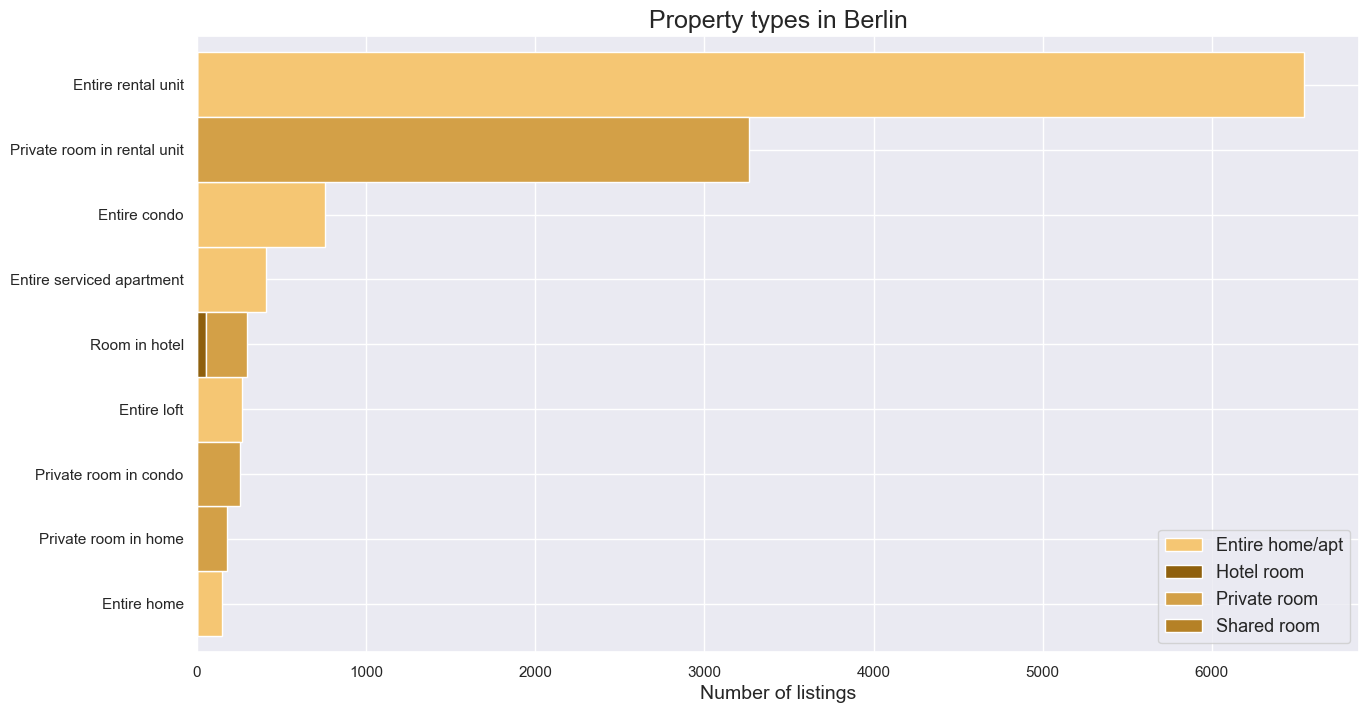

In [38]:
prop = listings.groupby(['property_type','room_type']).room_type.count()
prop = prop.unstack()
prop['total'] = prop.iloc[:,0:3].sum(axis = 1)
prop = prop.sort_values(by=['total'])
prop = prop[prop['total']>=100]
prop = prop.drop(columns=['total'])

prop.plot(kind='barh',stacked=True, color = [ "#F5C673","#8F600D", "#D3A047","#B58126"],
              linewidth = 1, grid=True, figsize=(15,8), width=1)
plt.title('Property types in Berlin', fontsize=18)
plt.xlabel('Number of listings', fontsize=14)
plt.ylabel("")
plt.legend(loc = 4,prop = {"size" : 13})
plt.rc('ytick', labelsize=13)
plt.show()

In [39]:
accom=listings['accommodates'].value_counts().sort_index()
accom

accommodates
1     1598
2     6275
3     1336
4     2206
5      544
6      694
7      124
8      159
9       35
10      54
11      13
12      37
13      12
14      16
15       6
16      25
Name: count, dtype: int64

### It is observed that the most common listings are for 2 people, followed by listings for 4 people


In [41]:
figAcom=px.bar(accom,title= "Most common type of accommodates",template= "plotly_dark", labels=dict(index="Accomodates",value="Listings"), width = 1000)
figAcom.update_yaxes(title_text='')
figAcom.update_xaxes(title_text='')
figAcom.update_layout(showlegend=False)
figAcom.update_traces(marker=dict(color="#FF9D4C"))  
figAcom.show()

### Who are the Hosts with the Most Listings and Where Are They Located?


In [42]:
private = listings[listings['room_type'] == "Private room"]
host_private = private.groupby(['host_id', 'host_name', 'neighbourhood_group']).size().reset_index(name='private_rooms').sort_values(by=['private_rooms'], ascending=False)
host_private.head()

host_id host_name       neighbourhood_group  private_rooms
3341  480052472    Janina  Friedrichshain-Kreuzberg             60
3427  529388435    Ramona  Friedrichshain-Kreuzberg             32
3343  480052472    Janina                    Pankow             21
3172  373476835    Marcin    Tempelhof - Schöneberg             15
3229  419001535      Dima                     Mitte             14

In [43]:
Janina = private[private['host_id']== 480052472]
Janina = Janina[['name','host_id', 'host_name', 'latitude', 'longitude']]
Janina.index.name = "listing_id"
Janina

name  \
listing_id                                                              
841970635674564608  Rental unit in Berlin · 1 bedroom · 1 bed · 1 ...   
841977048769390250  Rental unit in Berlin · 1 bedroom · 1 bed · 1 ...   
841980471049725670  Rental unit in Berlin · 1 bedroom · 1 bed · 1 ...   
850630696324700082  Rental unit in Berlin · 1 bedroom · 1 bed · 1 ...   
853315466343244038  Rental unit in Berlin · 1 bedroom · 1 bed · 1 ...   
...                                                               ...   
782624035738508837  Rental unit in Berlin · 1 bedroom · 1 bed · 1 ...   
888170783094558569  Rental unit in Berlin · 1 bedroom · 3 beds · 1...   
942560115426296415  Rental unit in Berlin · ★New · 1 bedroom · 1 b...   
942571807128973195  Rental unit in Berlin · ★New · 1 bedroom · 1 b...   
942584851180452307  Rental unit in Berlin · ★New · 1 bedroom · 1 b...   

                      host_id host_name   latitude  longitude  
listing_id                                                     
841970635674564608  480052472    Janina  52.550933  13.404384  
841977048769390250  480052472    Janina  52.551251  13.406070  
841980471049725670  480052472    Janina  52.551784  13.404106  
850630696324700082  480052472    Janina  52.547480  13.414302  
853315466343244038  480052472    Janina  52.549406  13.413064  
...                       ...       ...        ...        ...  
782624035738508837  480052472    Janina  52.478550  13.348510  
888170783094558569  480052472    Janina  52.480581  13.347872  
942560115426296415  480052472    Janina  52.480968  13.348310  
942571807128973195  480052472    Janina  52.478592  13.348368  
942584851180452307  480052472    Janina  52.478598  13.348010  

[102 rows x 5 columns]

In [44]:
JaninaMap = folium.Map(location=[52.516626523884305, 13.403950628235267], zoom_start=13)
for coord in Janina.itertuples(index=False):
    folium.Marker((coord.latitude, coord.longitude), tooltip=coord.name).add_to(JaninaMap)
JaninaMap

In [45]:
Ramona = private[private['host_id']== 529388435]
Ramona = Ramona[['name','host_id', 'host_name', 'latitude', 'longitude']]
Ramona.index.name = "listing_id"
Ramona.shape[0]

57

In [46]:
RamonaMap = folium.Map(location=[52.516626523884305, 13.403950628235267], zoom_start=13)
for coord in Ramona.itertuples(index=False):
    folium.Marker((coord.latitude, coord.longitude), tooltip=coord.name).add_to(RamonaMap)
RamonaMap

In [47]:
Marcin = private[private['host_id']== 373476835]
Marcin = Marcin[['name','host_id', 'host_name', 'latitude', 'longitude']]
Marcin.index.name = "listing_id"
Marcin

name  \
listing_id                                                              
46080792            Hotel in Berlin · ★4.68 · Studio · 1 bed · 1 p...   
46084713            Hotel in Berlin · ★4.12 · Studio · 2 beds · 1 ...   
46085840            Hotel in Berlin · ★4.71 · Studio · 2 beds · 1 ...   
46085885            Hotel in Berlin · ★4.40 · Studio · 1 bed · 1 p...   
46085887            Hotel in Berlin · Studio · 1 bed · 1 private bath   
583410830581023709          Hotel in Berlin · Studio · 1 bed · 1 bath   
583414576137949852  Hotel in Berlin · ★4.63 · Studio · 1 bed · 1 bath   
583756825005272097         Hotel in Berlin · Studio · 2 beds · 1 bath   
583797969376730215         Hotel in Berlin · Studio · 2 beds · 1 bath   
584748938247629166  Hotel in Berlin · ★4.16 · Studio · 2 beds · 1 ...   
584752929579312385  Hotel in Berlin · ★4.50 · Studio · 2 beds · 1 ...   
696276758292544954  Hotel in Berlin · ★4.67 · Studio · 1 bed · 1 bath   
696283985600661350  Hotel in Berlin · Studio · 1 bed · 1 private bath   
696291796972075200  Hotel in Berlin · Studio · 1 bed · 1 private bath   
696301429192052483  Hotel in Berlin · Studio · 1 bed · 1 private bath   

                      host_id host_name  latitude  longitude  
listing_id                                                    
46080792            373476835    Marcin  52.49867   13.34014  
46084713            373476835    Marcin  52.49830   13.33839  
46085840            373476835    Marcin  52.49714   13.33794  
46085885            373476835    Marcin  52.49829   13.33962  
46085887            373476835    Marcin  52.49676   13.33806  
583410830581023709  373476835    Marcin  52.49841   13.33955  
583414576137949852  373476835    Marcin  52.49791   13.33993  
583756825005272097  373476835    Marcin  52.49701   13.33814  
583797969376730215  373476835    Marcin  52.49695   13.33997  
584748938247629166  373476835    Marcin  52.49796   13.33997  
584752929579312385  373476835    Marcin  52.49698   13.33799  
696276758292544954  373476835    Marcin  52.49712   13.33807  
696283985600661350  373476835    Marcin  52.49854   13.33962  
696291796972075200  373476835    Marcin  52.49696   13.34005  
696301429192052483  373476835    Marcin  52.49814   13.33970

In [48]:
MarcinMap = folium.Map(location=[52.49867, 13.34014], zoom_start=15)
for coord in Marcin.itertuples(index=False):
    folium.Marker((coord.latitude, coord.longitude), tooltip=coord.name).add_to(MarcinMap)
MarcinMap

In [49]:
#Recuerden la opción para que pandas muestra más columnas
pd.options.display.max_columns = None

In [50]:
host_counts = listings.groupby(['host_id']).size().reset_index(name='num_host_listings')

In [51]:
host_counts.T

0     1     2      3      4      5      6      7      8     \
host_id            1581  2217  3718  10966  11622  12360  13823  33852  48159   
num_host_listings     3     3     1      1      1     21      1      1      1   

                    9      10     11     12     13     14     15     16    \
host_id            54283  55531  64696  68997  71331  71913  73158  81033   
num_host_listings      3      4      2      1      1      1     14      1   

                    17     18     19     20     21     22     23      24    \
host_id            84157  86159  86173  87357  89000  94918  98237  102461   
num_host_listings      1      1      2      1      1      1      1       8   

                     25      26      27      28      29      30      31    \
host_id            108391  112168  112675  119815  133204  137751  145583   
num_host_listings       1       1       1       1       6       1       3   

                     32      33      34      35      36      37      38    \
host_id            149093  150867  151200  156897  158127  159734  160191   
num_host_listings       1       1       9       1       1       1       1   

                     39      40      41      42      43      44      45    \
host_id            161221  161823  161864  162648  163384  168134  179110   
num_host_listings       5       1       1       1       9       1       1   

                     46      47      48      49      50      51      52    \
host_id            180779  181942  186851  193038  194957  201936  213446   
num_host_listings       1       1       1       1       1       1       1   

                     53      54      55      56      57      58      59    \
host_id            215318  218479  227954  246684  246890  248690  249501   
num_host_listings       1       1       1       1       1       1       1   

                     60      61      62      63      64      65      66    \
host_id            254200  255196  261488  264072  269771  281614  282786   
num_host_listings       1       1       1       1       1       3       2   

                     67      68      69      70      71      72      73    \
host_id            285237  286494  295111  296424  300965  302404  307296   
num_host_listings       1       5       1       1       1       8       1   

                     74      75      76      77      78      79      80    \
host_id            308441  312373  312427  312512  312896  315681  333589   
num_host_listings       3       1       1       1       1       1       1   

                     81      82      83      84      85      86      87    \
host_id            337396  342965  347279  351073  352520  353585  361507   
num_host_listings       1      17       1       1       1       1       1   

                     88      89      90      91      92      93      94    \
host_id            368264  369677  381006  386940  394381  399745  417276   
num_host_listings       2       1       1       1       1       1       1   

                     95      96      97      98      99      100     101   \
host_id            422981  424604  425899  428923  429311  435052  437628   
num_host_listings       1       1       1       1       1       1       2   

                     102     103     104     105     106     107     108   \
host_id            439886  443499  443681  447761  451311  452231  454103   
num_host_listings       1       2       1       1       1       1       1   

                     109     110     111     112     113     114     115   \
host_id            455670  456057  456085  467817  467895  472567  474705   
num_host_listings       2       1       2       1       1       4       1   

                     116     117     118     119     120     121     122   \
host_id            480184  483889  485838  490965  493012  496754  498957   
num_host_listings       1       1       4       1       1       1       1   

                     123     124     125     126     127    

In [52]:
host_prop = host_counts.groupby(['num_host_listings']).size().reset_index(name='count').transpose()
host_prop.columns = host_prop.iloc[0]
host_prop = host_prop.drop(host_prop.index[0])
host_prop
 

num_host_listings   1    2    3    4    5    6    7    8    9    10   11   \
count              8012  686  194   94   46   41   36   24   19   15    6   

num_host_listings  12   13   14   15   16   17   18   19   20   21   24   27   \
count                7    3    6    2    1    2    3    1    2    3    2    1   

num_host_listings  33   34   35   38   44   49   50   58   67   76   113  114  \
count                1    1    1    1    1    2    1    1    1    1    1    1   

num_host_listings  187  
count                1

In [53]:
over20 = host_counts[host_counts['num_host_listings']>=20] 
over20 = over20.sort_values(by='num_host_listings',ascending=False)
over20

host_id  num_host_listings
8609  434485440                187
8319  367035318                114
8877  480052472                113
8529  418270816                 76
9177  529388435                 67
8696  449692327                 58
8163  335573202                 50
1778    8250486                 49
8724  454962512                 49
7369  210700814                 44
8369  378071271                 38
1883    8912086                 35
7827  271235180                 34
761     3003519                 33
6136  102979040                 27
8531  419001535                 24
7108  177712632                 24
6870  155105708                 21
5884   87442687                 21
5         12360                 21
7784  265635773                 20
7251  193643890                 20

### Average Price for Two People by Neighborhood


<function matplotlib.pyplot.show(close=None, block=None)>

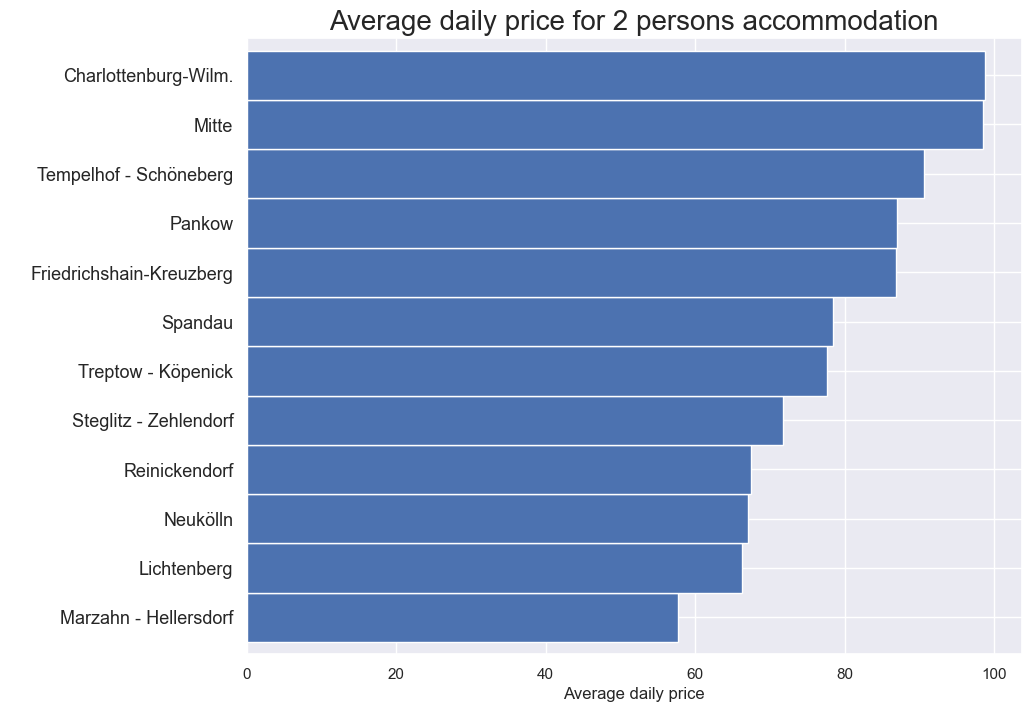

In [55]:
avgPNaccom = listings[ listings['accommodates']==2]
avgPNaccom = avgPNaccom.groupby('neighbourhood_group')['price'].mean().sort_values(ascending=True)
avgPNaccom.plot.barh (figsize=(10,8),color='b',width = 1)
plt.title('Average daily price for 2 persons accommodation',fontsize = 20)
plt.xlabel('Average daily price')
plt.ylabel(' ')
plt.show

In [58]:
BerlinNeigh = BerNeigh.reset_index() 
BerlinNeigh = BerlinNeigh.merge(listings.groupby('neighbourhood_group')['price'].mean().reset_index(), on='neighbourhood_group', how='left')
BerlinNeigh.rename(columns={'price': 'average_price'}, inplace=True)
print(BerlinNeigh)


         neighbourhood_group  count  average_price
0      Marzahn - Hellersdorf    106      79.818396
1              Reinickendorf    202      73.003094
2                    Spandau    207      55.943237
3      Steglitz - Zehlendorf    306      90.732435
4                Lichtenberg    345      89.331884
5         Treptow - Köpenick    524      91.262405
6     Tempelhof - Schöneberg    918     106.627451
7       Charlottenburg-Wilm.   1209     115.465674
8                   Neukölln   1555      77.524116
9                     Pankow   2058     111.743197
10                     Mitte   2833     131.090187
11  Friedrichshain-Kreuzberg   2871     104.628004


## Below are maps displaying the average prices in each neighborhood


In [59]:
berlin = gpd.read_file("data/neighbourhoods.geojson")
BerlinNeigh = BerlinNeigh
berlin = pd.merge(berlin, BerlinNeigh, on = 'neighbourhood_group',how='left')
berlin.average_price = berlin.average_price.round(decimals=2)

In [60]:
map_dict = berlin.set_index('neighbourhood_group')['average_price'].to_dict()
min_value = min(map_dict.values())
max_value = max(map_dict.values())

color_scale = LinearColormap(['yellow', 'red'], vmin=min_value, vmax=max_value)

def get_color(feature):
    value = map_dict.get(feature['properties']['neighbourhood_group'])
    if value is not None:
        return color_scale(value)
    else:
        return 'grey'

In [61]:
map3 = folium.Map(location=[52.516626523884305, 13.403950628235267], zoom_start=11)
folium.GeoJson(data=berlin,
               name='Berlin',
               tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood_group', 'average_price'],
                                                      labels=True,
                                                      sticky=False),
               style_function= lambda feature: {
                   'fillColor': get_color(feature),
                   'color': 'black',
                   'weight': 1,
                   'dashArray': '5, 5',
                   'fillOpacity': 0.5
               },
               highlight_function=lambda feature: {'weight': 3, 'fillColor': get_color(feature), 'fillOpacity': 0.8}).add_to(map3)
map3

In [62]:
map4 = folium.Map(location=[52.516626523884305, 13.403950628235267], zoom_start=11)
folium.GeoJson(data=berlin,
               name='Berlin',
               tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood_group', 'average_price'],
                                                      labels=True,
                                                      sticky=False),
               style_function= lambda feature: {
                   'fillColor': get_color(feature),
                   'color': 'black',
                   'weight': 1,
                   'dashArray': '5, 5',
                   'fillOpacity':0.9
                   },
               highlight_function=lambda feature: {'weight':3, 'fillColor': get_color(feature), 'fillOpacity': 0.8}).add_to(map4)
map4

### Location Ratings vs. Average Price for Two People by Neighborhood

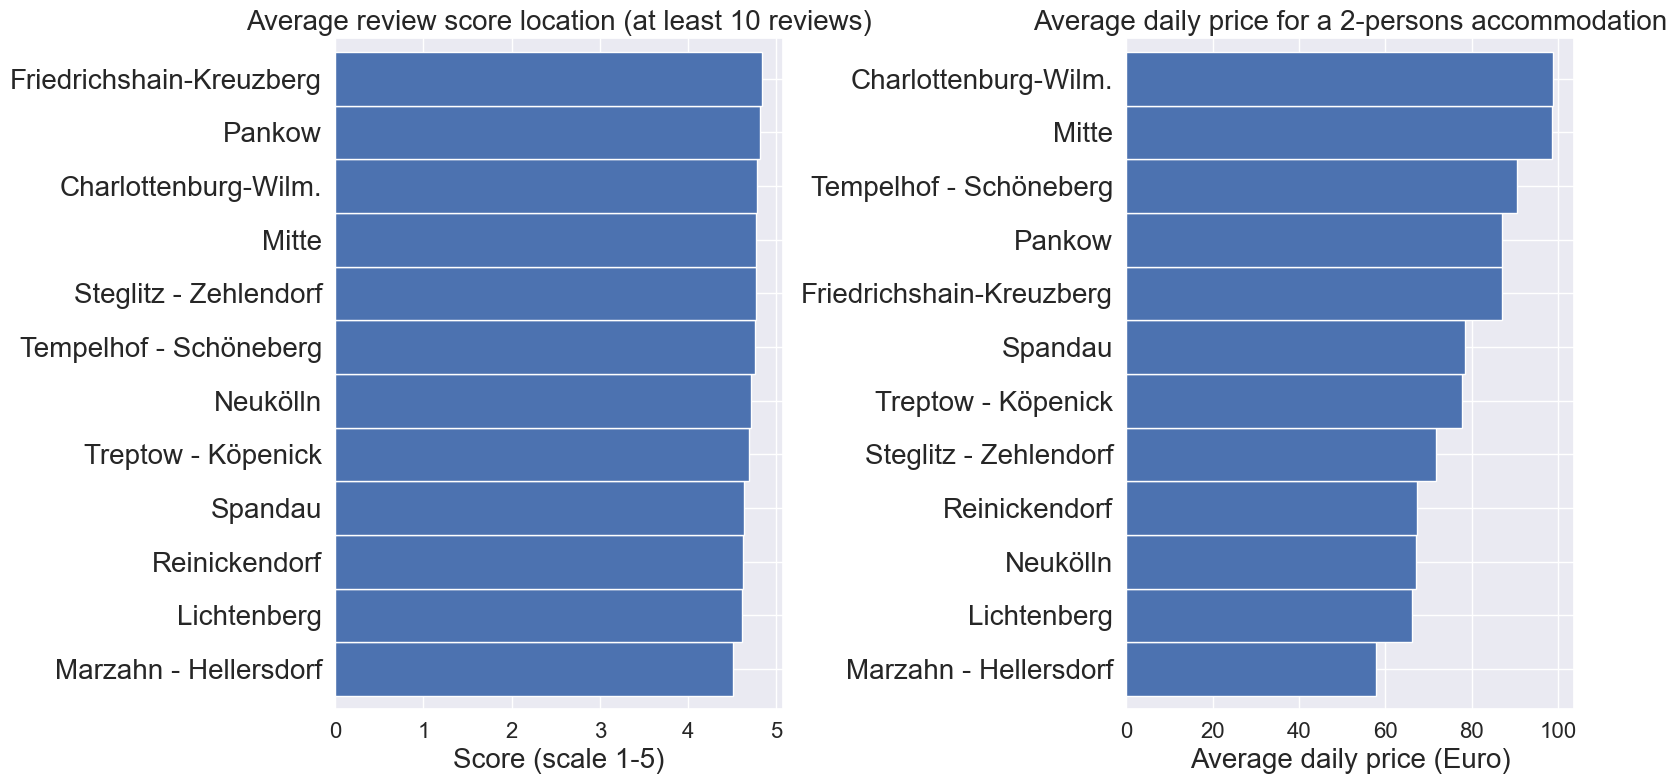

In [149]:
fig = plt.figure(figsize=(16, 8))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

ax1 = fig.add_subplot(121)
feq = listings[listings['number_of_reviews']>=10]
feq1 = feq.groupby('neighbourhood_group')['review_scores_location'].mean().sort_values(ascending=True)
ax1=feq1.plot.barh(color='b', width=1)
plt.title("Average review score location (at least 10 reviews)", fontsize=20)
plt.xlabel('Score (scale 1-5)', fontsize=20)
plt.ylabel("")

ax2 = fig.add_subplot(122)
feq = listings[listings['accommodates']==2]
feq2 = feq.groupby('neighbourhood_group')['price'].mean().sort_values(ascending=True)
ax2=feq2.plot.barh(color='b', width=1)
plt.title("Average daily price for a 2-persons accommodation", fontsize=20)
plt.xlabel('Average daily price (Euro)', fontsize=20)
plt.ylabel("")

plt.tight_layout()
plt.show()

In [155]:
feq2

neighbourhood_group
Marzahn - Hellersdorf       57.744565
Lichtenberg                 66.191176
Neukölln                    67.006039
Reinickendorf               67.394578
Steglitz - Zehlendorf       71.747159
Treptow - Köpenick          77.647186
Spandau                     78.394068
Friedrichshain-Kreuzberg    86.863314
Pankow                      86.985758
Tempelhof - Schöneberg      90.531106
Mitte                       98.445967
Charlottenburg-Wilm.        98.704974
Name: price, dtype: float64

### High Overall Ratings for Various Aspects to Be Evaluated

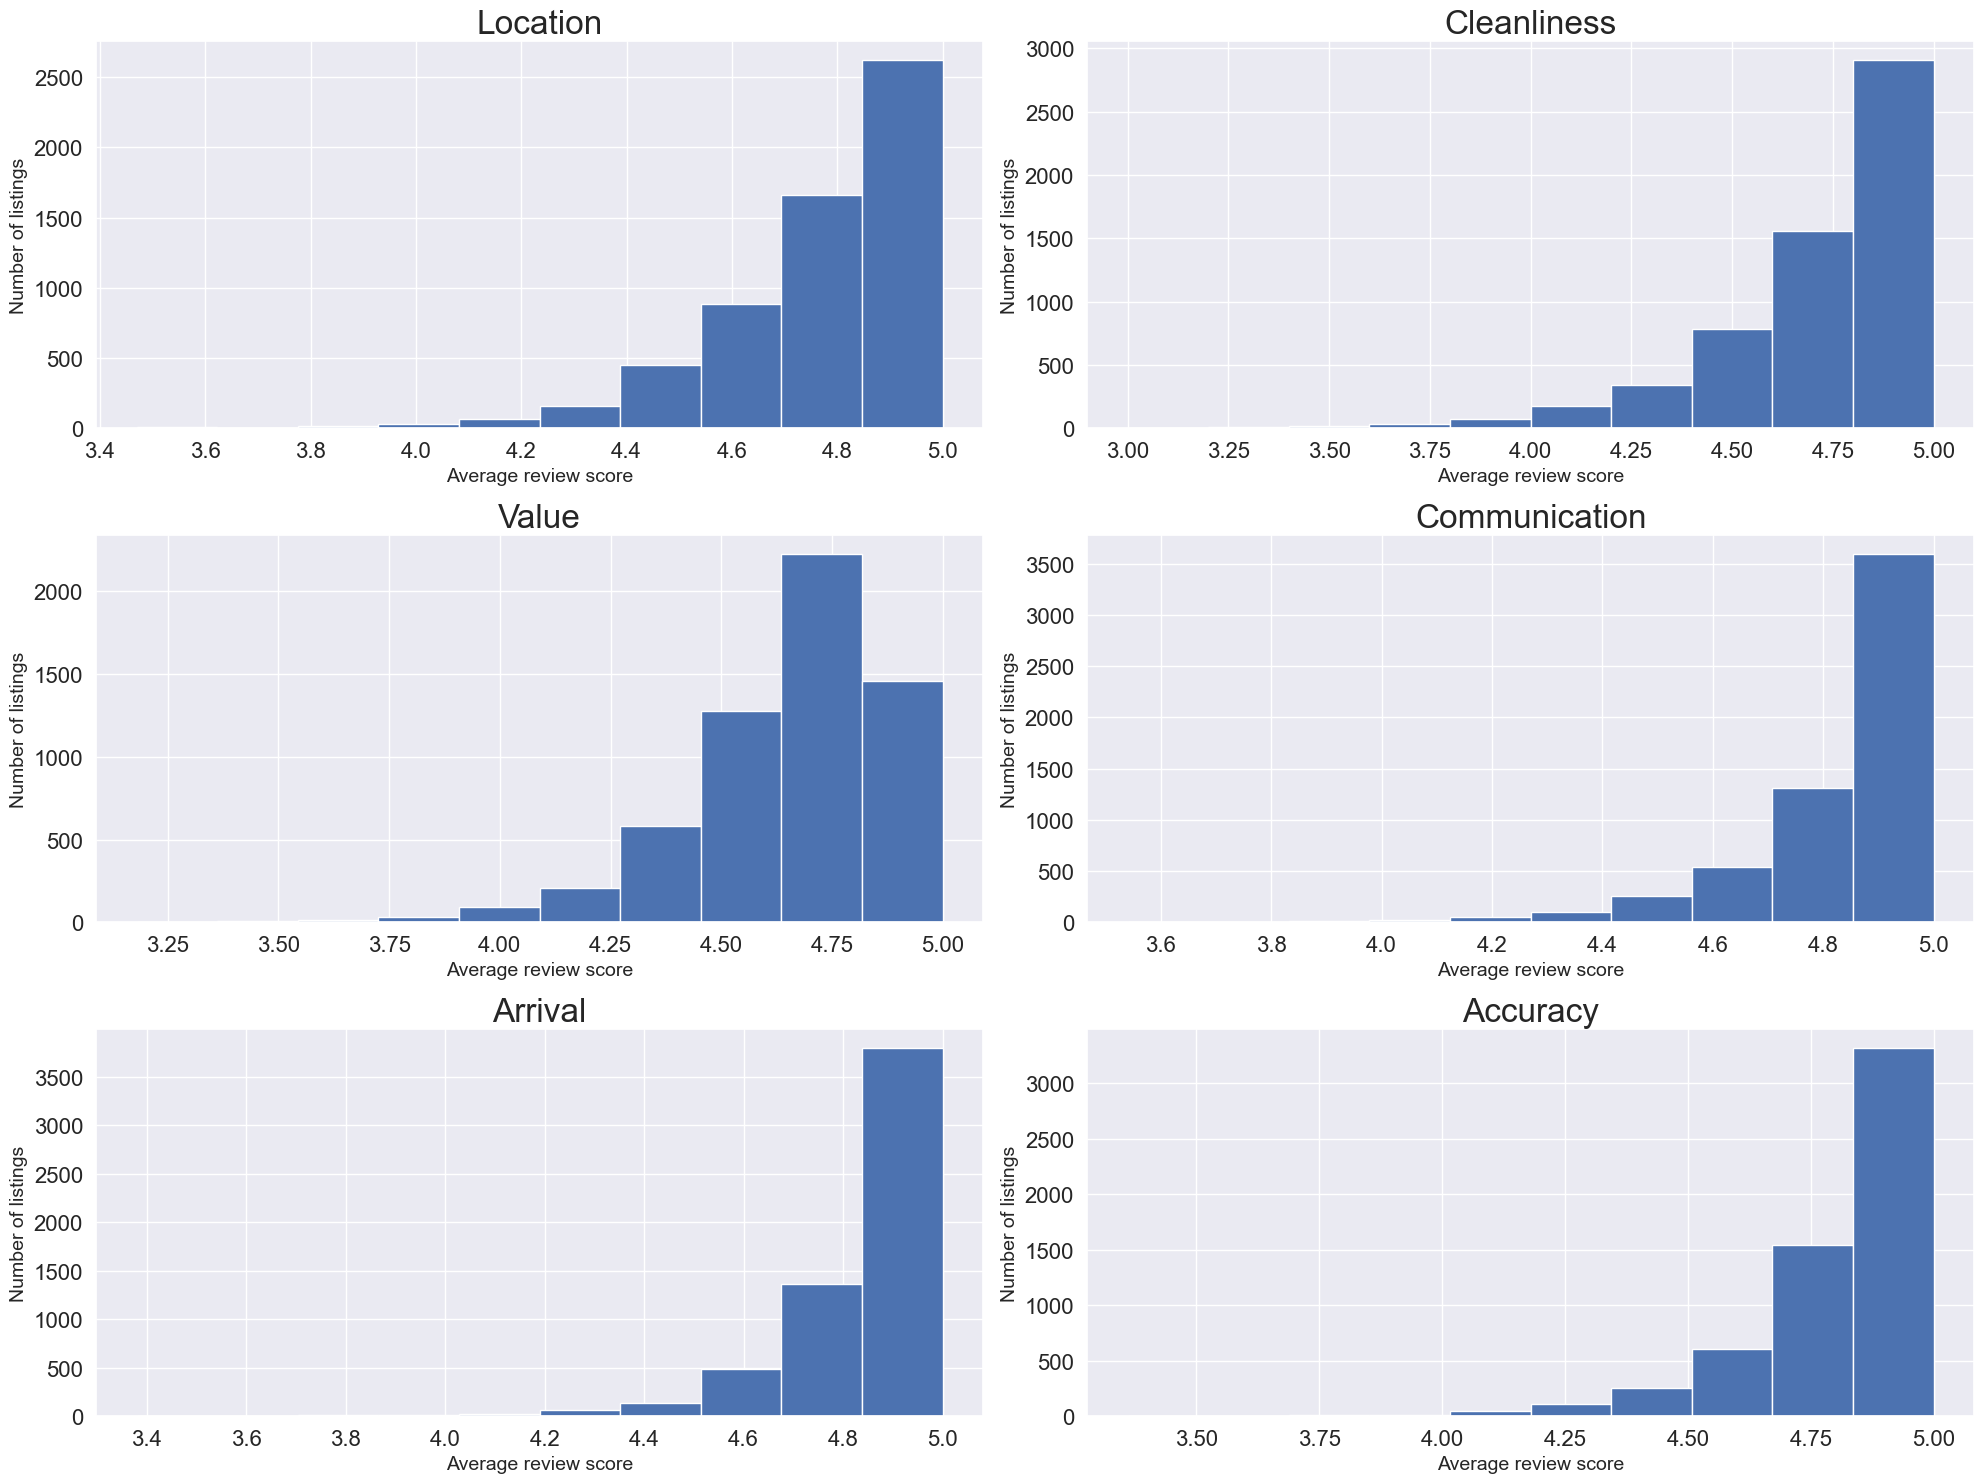

In [65]:
listings10 = listings[listings['number_of_reviews'] >= 10]

fig = plt.figure(figsize=(20, 15))
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)

ax1 = fig.add_subplot(321)
listings10['review_scores_location'].plot.hist(color='b', bins=10)
plt.title("Location", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax2 = fig.add_subplot(322)
listings10['review_scores_cleanliness'].plot.hist(color='b', bins=10) 
plt.title("Cleanliness", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)


ax3 = fig.add_subplot(323)
listings10['review_scores_value'].plot.hist(color='b', bins=10) 
plt.title("Value", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)


ax4 = fig.add_subplot(324)
listings10['review_scores_communication'].plot.hist(color='b', bins=10)
plt.title("Communication", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)


ax5 = fig.add_subplot(325)
listings10['review_scores_checkin'].plot.hist(color='b', bins=10)
plt.title("Arrival", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)


ax6 = fig.add_subplot(326)
listings10['review_scores_accuracy'].plot.hist(color='b', bins=10)
plt.title("Accuracy", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

plt.tight_layout()
plt.show()


## How Many Hosts Are Considered Superhosts? Is It Worth It?

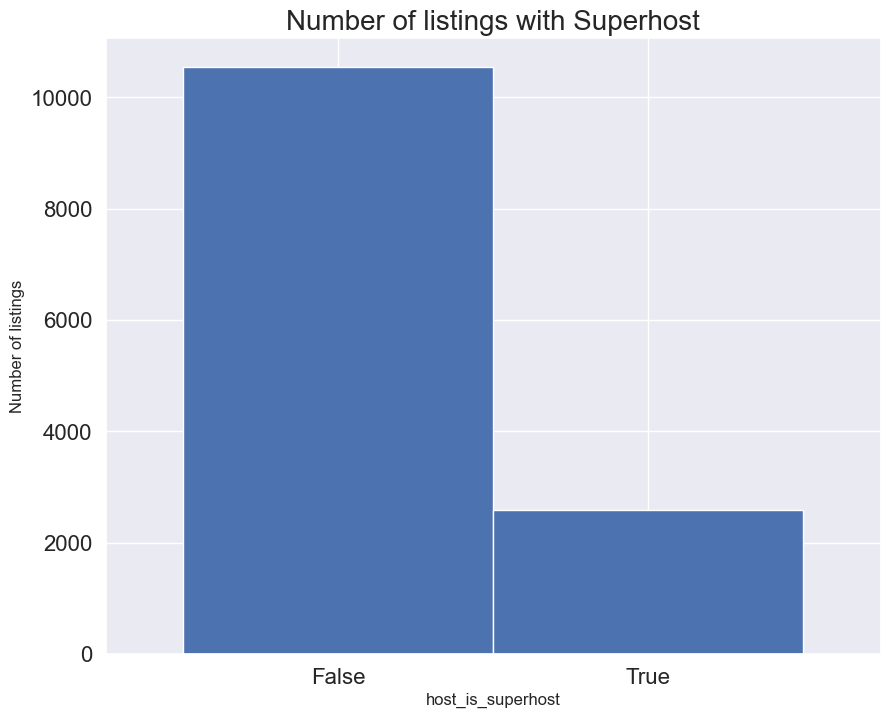

In [66]:
listings.host_is_superhost = listings.host_is_superhost.replace({"t": "True", "f": "False"})

feq=listings['host_is_superhost'].value_counts()
feq.plot.bar(figsize=(10, 8), width=1, rot=0)
plt.title("Number of listings with Superhost", fontsize=20)
plt.ylabel('Number of listings', fontsize=12)
plt.show()

In [67]:
px.pie(feq ,names = feq.index, values=feq.values,width = 1000, template= "plotly_dark", title="Number of listings with Superhost")

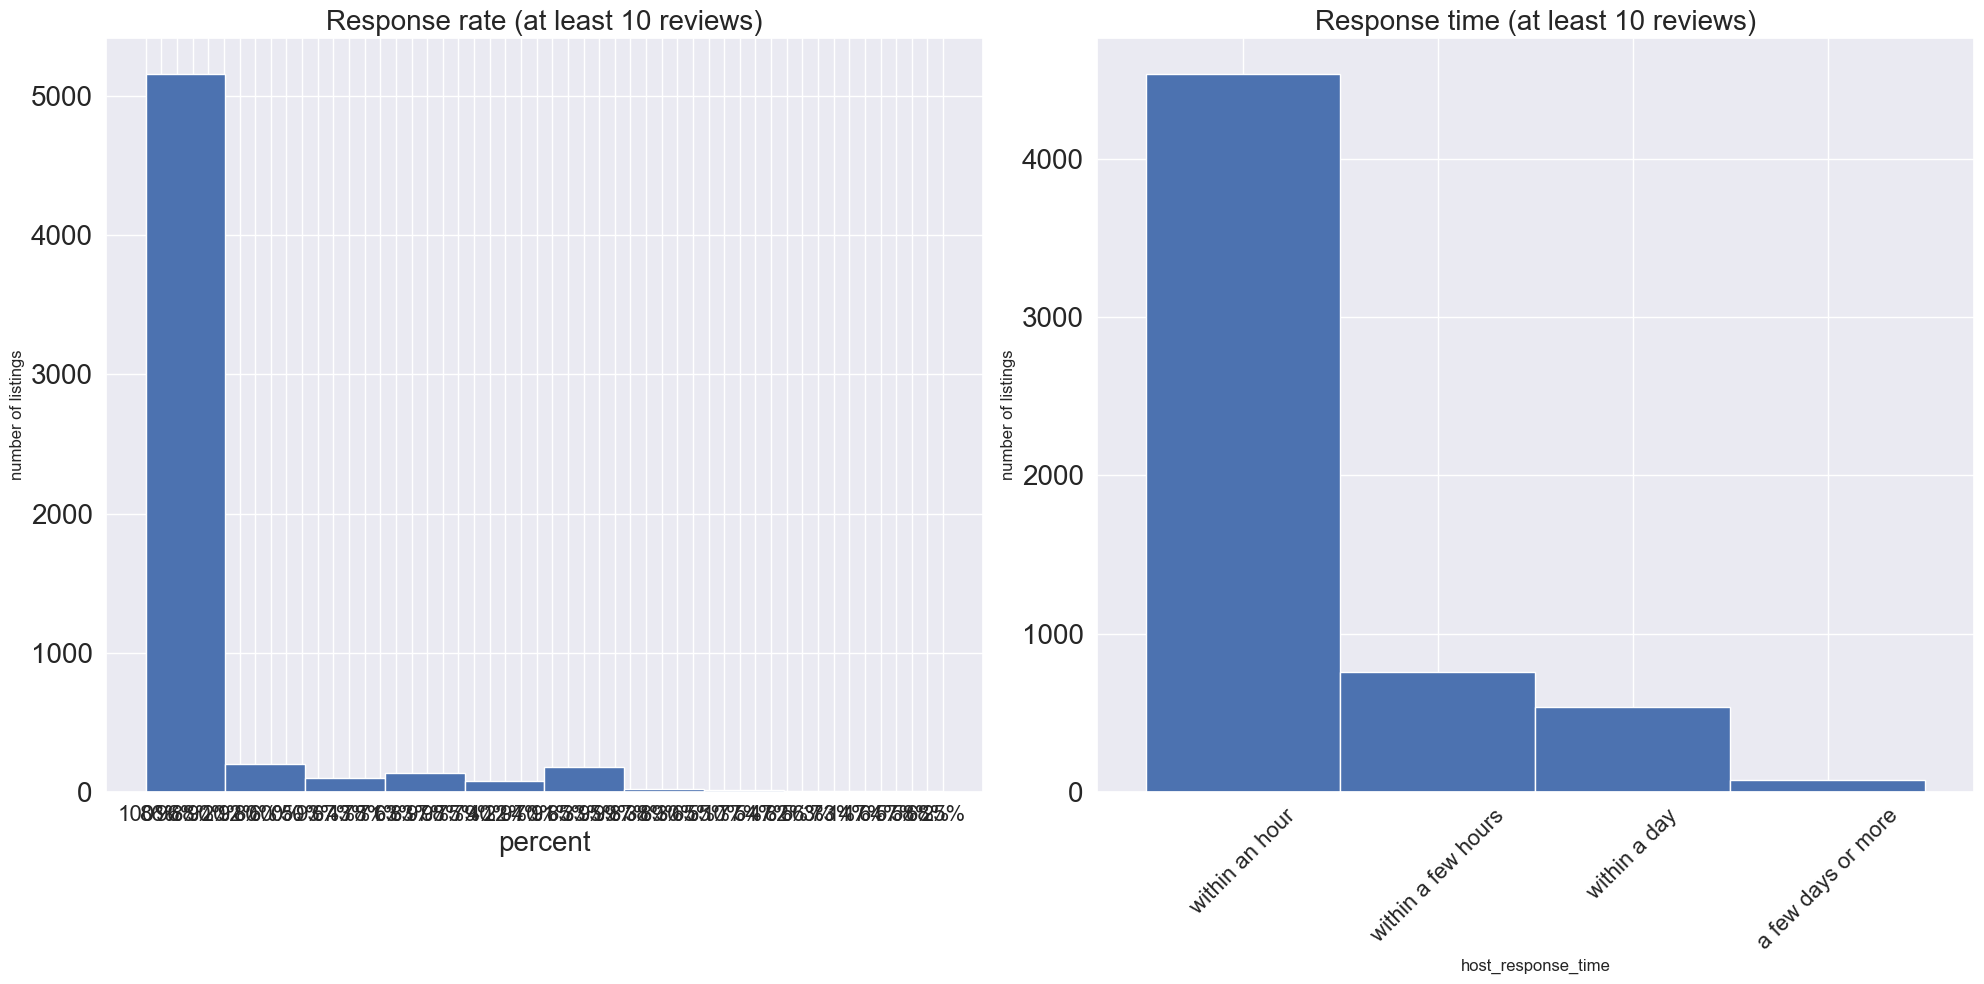

In [108]:
fig = plt.figure(figsize=(20,10))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

ax1 = fig.add_subplot(121)
feq1 = listings10['host_response_rate'].dropna()
ax1.hist(feq1)
plt.title("Response rate (at least 10 reviews)", fontsize=20)
plt.ylabel("number of listings")
plt.xlabel("percent", fontsize=20)

ax2 = fig.add_subplot(122)
feq2 = listings10['host_response_time'].value_counts()
ax2=feq2.plot.bar(color='b', width=1, rot=45)
plt.title("Response time (at least 10 reviews)", fontsize=20)
plt.ylabel("number of listings")

plt.tight_layout()
plt.show()


In [70]:
calendar.head()

date available   price adjusted_price  minimum_nights  \
listing_id                                                               
3176       2023-09-16         f  $83.00         $83.00              63   
3176       2023-09-17         f  $83.00         $83.00              63   
3176       2023-09-18         f  $83.00         $83.00              63   
3176       2023-09-19         f  $83.00         $83.00              63   
3176       2023-09-20         f  $83.00         $83.00              63   

            maximum_nights  
listing_id                  
3176                   184  
3176                   184  
3176                   184  
3176                   184  
3176                   184

In [71]:
exchange_rate = 0.94206588

calendar['price'] = (calendar['price'].str.replace('$', '').str.replace(',', '').astype(float)*exchange_rate)

calendar['adjusted_price'] = (calendar['adjusted_price'].str.replace('$', '').str.replace(',', '').astype(float) * exchange_rate)

In [72]:
calendar.price = calendar.price
calendar['price'] = pd.to_numeric(calendar['price'])
calendar = calendar[calendar.date < '2024-09-14']

In [73]:
calendar.head()

date available      price  adjusted_price  minimum_nights  \
listing_id                                                                   
3176       2023-09-16         f  78.191468       78.191468              63   
3176       2023-09-17         f  78.191468       78.191468              63   
3176       2023-09-18         f  78.191468       78.191468              63   
3176       2023-09-19         f  78.191468       78.191468              63   
3176       2023-09-20         f  78.191468       78.191468              63   

            maximum_nights  
listing_id                  
3176                   184  
3176                   184  
3176                   184  
3176                   184  
3176                   184

In [74]:
print(calendar.shape)

(4780750, 6)


In [75]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4780750 entries, 3176 to 981159693242362351
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   available       object        
 2   price           float64       
 3   adjusted_price  float64       
 4   minimum_nights  int64         
 5   maximum_nights  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 255.3+ MB


### Using the Calendar to Observe Availability in the Coming Months

In [76]:
sum_available = calendar[calendar.available == "t"].groupby(['date']).size().to_frame(name= 'available').reset_index()
sum_available['weekday'] = sum_available['date'].dt.day_name()
sum_available = sum_available.set_index('date')
 
sum_available.iplot(y='available', mode = 'lines', xTitle = 'Date', yTitle = 'number of listings available',\
                   text='weekday', title = 'Number of listings available by date')

### Using the Calendar to Observe the Average Price for Couples for a Minimum 4-Night Stay


In [77]:
calendar['price'] = pd.to_numeric(calendar['price'], errors='coerce')

average_price = calendar[(calendar.available == "t") & (calendar.minimum_nights == 3.0)].groupby(['date'])['price'].mean().astype(int).reset_index()
average_price['weekday'] = average_price['date'].dt.day_name()

average_price = average_price.set_index('date')

average_price.iplot(y='price', mode='lines', xTitle='Date', yTitle='Price',
    text='weekday', title='Average price for 4 nights as minimum by date')

## Mining Comments to Highlight the Most Commonly Mentioned Words About Staying in the City


In [78]:
reviews_details.head()

listing_id      id       date  reviewer_id reviewer_name  \
0        3176    4283 2009-06-20        21475         Milan   
1        3176  134722 2010-11-07       263467        George   
2        3176  144064 2010-11-24        76726      Patricia   
3        3176  156702 2010-12-21       291657     Benedetta   
4        3176  165048 2011-01-04       279789          Aude   

                                            comments  
0  excellent stay, i would highly recommend it. a...  
1  Britta's apartment in Berlin is in a great are...  
2  Fantastic, large place in good location. Only ...  
3  L'appartamento di Britta è molto largo carino ...  
4  We went in Berlin for the new year eve. The ap...

In [79]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joseba\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [80]:
# Filter out empty comments
reviews_details = reviews_details[reviews_details['comments'].notnull()]

# Remove numbers
reviews_details['comments'] = reviews_details['comments'].str.replace('\d+', '')

# Convert text to lowercase
reviews_details['comments'] = reviews_details['comments'].str.lower()

# Remove Windows new line characters
reviews_details['comments'] = reviews_details['comments'].str.replace('\r\n', '')

# Use German stopwords from NLTK
stop_german = stopwords.words("german")
reviews_details['comments'] = reviews_details['comments'].apply(lambda x: " ".join([i for i in x.split() 
                                                                                    if i not in (stop_german)]))

# Remove punctuation
reviews_details['comments'] = reviews_details['comments'].str.replace('[^\w\s]', ' ')

# Replace multiple spaces with a single space
reviews_details['comments'] = reviews_details['comments'].str.replace('\s+', ' ')

# Print an example comment
print(reviews_details.comments.values[2])

fantastic, large place good location. only a short tram ride to alexanderplatz u-s bahn, with connections across berlin. britta quick to reply to all messages and gave very clear instructions regarding directions, key pick up and things to know about the place. try gargerin cafe around the corner for lovely and cheap continental breakfast. i definitely recommend this apartment!


In [81]:
reviews_details = reviews_details[reviews_details['comments'].notnull()]

#remove numbers
reviews_details['comments'] = reviews_details['comments'].str.replace('\d+', '') 
#all to lowercase
reviews_details['comments'] = reviews_details['comments'].str.lower()
#remove windows new line
reviews_details['comments'] = reviews_details['comments'].str.replace('\r\n', "")
#remove stopwords (from nltk library)
stop_english = stopwords.words("english")
reviews_details['comments'] = reviews_details['comments'].apply(lambda x: " ".join([i for i in x.split() 
                                                      if i not in (stop_english)]))
# remove punctuation
reviews_details['comments'] = reviews_details['comments'].str.replace('[^\w\s]'," ")
# replace x spaces by one space
reviews_details['comments'] = reviews_details['comments'].str.replace('\s+', ' ')

reviews_details.comments.values[2]

'fantastic, large place good location. short tram ride alexanderplatz u-s bahn, connections across berlin. britta quick reply messages gave clear instructions regarding directions, key pick things know place. try gargerin cafe around corner lovely cheap continental breakfast. definitely recommend apartment!'

In [82]:
texts = reviews_details.comments.tolist()

vec = CountVectorizer().fit(texts)
bag_of_words = vec.transform(texts)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

cvec_df = pd.DataFrame.from_records(words_freq, columns= ['words', 'counts']).sort_values(by="counts", ascending=False)
cvec_df.head(10)

words  counts
95          br  221131
20       great  152375
18   apartment  143494
36       place  120630
19      berlin  117783
1         stay  116163
38    location   96554
6         nice   89433
140      clean   81170
490      super   80527

In [83]:
top50 = cvec_df.head(50)

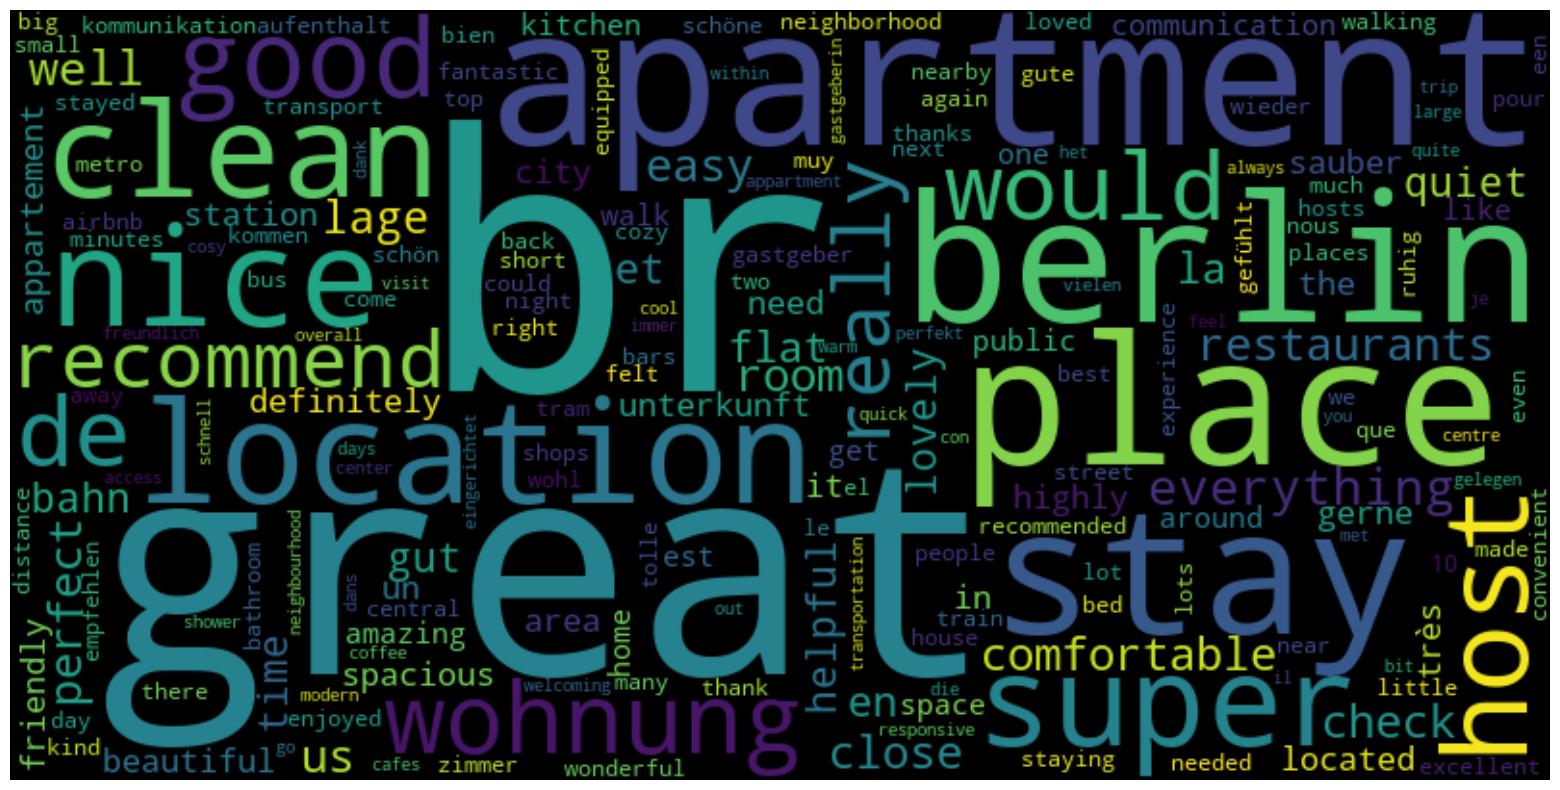

In [84]:
cvec_dict = dict(zip(cvec_df.words, cvec_df.counts))

wordcloud = WordCloud(width=800, height=400)
wordcloud.generate_from_frequencies(frequencies=cvec_dict)
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

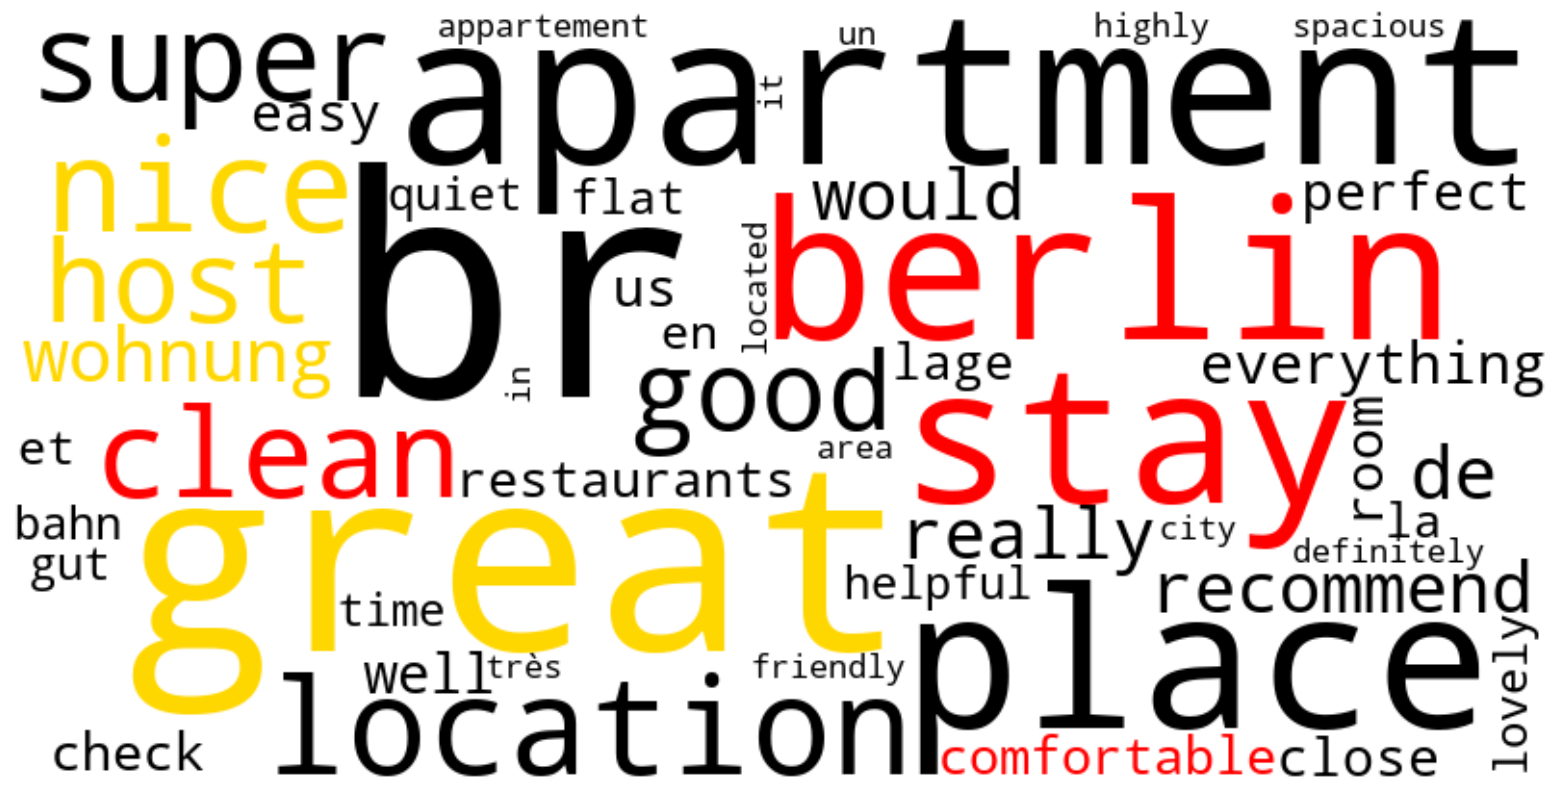

In [85]:
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    german_flag_colors = {
        "place": "black",
        "berlin": "red",
        "great": "gold",
        "apartment": "black",
        "comfortable": "red",
        "host": "gold",
        "location": "black",
        "stay": "red",
        "nice": "gold",
        "restaurant": "black",
        "clean": "red",
        "wohnung": "gold"
    }
    
    return german_flag_colors.get(word, "black")

wordcloud = WordCloud(width=800, height=400, color_func=color_func)

wordcloud = WordCloud(width=800, height=400, color_func=color_func)

cvec_dict = dict(zip(top50.words, top50.counts))

wordcloud = WordCloud(width=800, height=400, background_color="white", color_func=color_func)
wordcloud.generate_from_frequencies(frequencies=cvec_dict)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [86]:
calendar

date available      price  adjusted_price  \
listing_id                                                           
3176               2023-09-16         f  78.191468       78.191468   
3176               2023-09-17         f  78.191468       78.191468   
3176               2023-09-18         f  78.191468       78.191468   
3176               2023-09-19         f  78.191468       78.191468   
3176               2023-09-20         f  78.191468       78.191468   
...                       ...       ...        ...             ...   
981159693242362351 2024-09-09         f  63.118414       63.118414   
981159693242362351 2024-09-10         f  55.581887       55.581887   
981159693242362351 2024-09-11         f  59.350150       59.350150   
981159693242362351 2024-09-12         f  53.697755       53.697755   
981159693242362351 2024-09-13         f  62.176348       62.176348   

                    minimum_nights  maximum_nights  
listing_id                                          
3176                            63             184  
3176                            63             184  
3176                            63             184  
3176                            63             184  
3176                            63             184  
...                            ...             ...  
981159693242362351              92             180  
981159693242362351              92             180  
981159693242362351              92             180  
981159693242362351              92             180  
981159693242362351              92             180  

[4780750 rows x 6 columns]

## Web Scraping on Wikipedia to Gather Climatic Data

In [87]:
from bs4 import BeautifulSoup
import requests

In [88]:
url = 'https://es.wikipedia.org/wiki/Berl%C3%ADn'
text_web = requests.get(url).text
print(text_web)

<!DOCTYPE html>
<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-sticky-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-enabled vector-feature-zebra-design-disabled vector-feature-custom-font-size-clientpref-0 vector-feature-client-preferences-disabled vector-feature-typography-survey-disabled vector-toc-available" lang="es" dir="ltr">
<head>
<meta charset="UTF-8">
<title>Berlín - Wikipedia, la enciclopedia libre</title>
<script>(function(){var className="client-js vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-sticky-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limit

In [89]:
soup = BeautifulSoup(text_web,'lxml')
print(soup)

<!DOCTYPE html>
<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-sticky-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-enabled vector-feature-zebra-design-disabled vector-feature-custom-font-size-clientpref-0 vector-feature-client-preferences-disabled vector-feature-typography-survey-disabled vector-toc-available" dir="ltr" lang="es">
<head>
<meta charset="utf-8"/>
<title>Berlín - Wikipedia, la enciclopedia libre</title>
<script>(function(){var className="client-js vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-sticky-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limi

In [90]:
print(soup.prettify())

<!DOCTYPE html>
<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-sticky-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-enabled vector-feature-zebra-design-disabled vector-feature-custom-font-size-clientpref-0 vector-feature-client-preferences-disabled vector-feature-typography-survey-disabled vector-toc-available" dir="ltr" lang="es">
 <head>
  <meta charset="utf-8"/>
  <title>
   Berlín - Wikipedia, la enciclopedia libre
  </title>
  <script>
   (function(){var className="client-js vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-sticky-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled v

In [91]:
print(soup.title)
print(soup.title.string)

<title>Berlín - Wikipedia, la enciclopedia libre</title>
Berlín - Wikipedia, la enciclopedia libre


In [92]:
tablas = soup.find_all('table',class_ = 'wikitable collapsible')
tablas

[<table class="wikitable collapsible" style="width:60%; text-align:center; font-size:90%;">
 <tbody><tr>
 <th colspan="14" style="font-weight:bold"><span typeof="mw:File"><span><img class="mw-file-element" data-file-height="48" data-file-width="48" decoding="async" height="30" src="//upload.wikimedia.org/wikipedia/commons/thumb/5/57/Gnome-weather-few-clouds.svg/30px-Gnome-weather-few-clouds.svg.png" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/5/57/Gnome-weather-few-clouds.svg/45px-Gnome-weather-few-clouds.svg.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/5/57/Gnome-weather-few-clouds.svg/60px-Gnome-weather-few-clouds.svg.png 2x" width="30"/></span></span>  Parámetros climáticos promedio de Berlín Brandenburgo (normales 1991–2020, extremos 1957–2021) <span typeof="mw:File"><span><img class="mw-file-element" data-file-height="200" data-file-width="200" decoding="async" height="30" src="//upload.wikimedia.org/wikipedia/commons/thumb/a/ab/WPTC_Meteo_task_force.svg/30p

In [93]:
wiki = pd.read_html(str(tablas))

In [94]:
wiki

[  Parámetros climáticos promedio de Berlín Brandenburgo (normales 1991–2020, extremos 1957–2021)  \
                                                                                              Mes   
 0                               Temp. máx. abs. (°C)                                               
 1                              Temp. máx. media (°C)                                               
 2                                   Temp. media (°C)                                               
 3                              Temp. mín. media (°C)                                               
 4                               Temp. mín. abs. (°C)                                               
 5                           Precipitación total (mm)                                               
 6                                       Horas de sol                                               
 7  Fuente: Data derived from Deutscher Wetterdien...                                      

In [95]:
clima = wiki[0]
clima

Parámetros climáticos promedio de Berlín Brandenburgo (normales 1991–2020, extremos 1957–2021)  \
                                                                                             Mes   
0                               Temp. máx. abs. (°C)                                               
1                              Temp. máx. media (°C)                                               
2                                   Temp. media (°C)                                               
3                              Temp. mín. media (°C)                                               
4                               Temp. mín. abs. (°C)                                               
5                           Precipitación total (mm)                                               
6                                       Horas de sol                                               
7  Fuente: Data derived from Deutscher Wetterdien...                                               

                                                      \
                                                Ene.   
0                                               15.1   
1                                                3.2   
2                                                0.7   
3                                               -2.2   
4                                              -25.3   
5                                               41.5   
6                                               52.6   
7  Fuente: Data derived from Deutscher Wetterdien...   

                                                      \
                                                Feb.   
0                                               19.2   
1                                                4.9   
2                                                1.6   
3                                               -1.8   
4                                              -22.0   
5                                               30.0   
6                                               77.9   
7  Fuente: Data derived from Deutscher Wetterdien...   

                                                      \
                                                Mar.   
0                                               25.8   
1                                                9.0   
2                                                4.6   
3                                                0.4   
4                                              -19.1   
5                                               35.9   
6                                              126.7   
7  Fuente: Data derived from Deutscher Wetterdien...   

                                                      \
                                                Abr.   
0                                               30.8   
1                                               15.1   
2                                                9.7   
3                                                4.0   
4                                               -7.4   
5                                               27.7   
6                                              196.4   
7  Fuente: Data derived from Deutscher Wetterdien...   

                                                      \
                                                May.   
0                                               32.7   
1                                               19.6   
2                                               14.2   
3                                                8.2   
4                                               -2.8   
5                                               52.8   
6                                              231.1   
7  Fuente: Data derived from Deutscher Wetterdien...   

                                                      \
                                                Jun.   
0                                               38.4   
1                           

In [96]:
clima.columns = ["Mes","Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic", "Anual"]
clima=clima.set_index('Mes')
clima = clima.T
clima

Mes   Temp. máx. abs. (°C) Temp. máx. media (°C) Temp. media (°C)  \
Ene                   15.1                   3.2              0.7   
Feb                   19.2                   4.9              1.6   
Mar                   25.8                   9.0              4.6   
Abr                   30.8                  15.1              9.7   
May                   32.7                  19.6             14.2   
Jun                   38.4                  22.9             17.6   
Jul                   38.3                  25.0             19.6   
Ago                   38.0                  24.8             19.2   
Sep                   32.3                  19.8             14.7   
Oct                   27.7                  13.9              9.6   
Nov                   20.9                   7.7              4.9   
Dic                   15.6                   4.1              1.8   
Anual                 38.4                  14.2              9.9   

Mes   Temp. mín. media (°C) Temp. mín. abs. (°C) Precipitación total (mm)  \
Ene                    -2.2                -25.3                     41.5   
Feb                    -1.8                -22.0                     30.0   
Mar                     0.4                -19.1                     35.9   
Abr                     4.0                 -7.4                     27.7   
May                     8.2                 -2.8                     52.8   
Jun                    11.7                  1.3                     60.2   
Jul                    14.0                  4.9                     70.0   
Ago                    13.5                  4.6                     52.4   
Sep                     9.8                 -0.9                     43.6   
Oct                     5.6                 -7.7                     40.3   
Nov                     1.9                -17.8                     38.8   
Dic                    -0.9                -24.0                     39.1   
Anual                   5.4                -25.3                    532.3   

Mes   Horas de sol Fuente: Data derived from Deutscher Wetterdienst[18]​  
Ene           52.6  Fuente: Data derived from Deutscher Wetterdien...     
Feb           77.9  Fuente: Data derived from Deutscher Wetterdien...     
Mar          126.7  Fuente: Data derived from Deutscher Wetterdien...     
Abr          196.4  Fuente: Data derived from Deutscher Wetterdien...     
May          231.1  Fuente: Data derived from Deutscher Wetterdien...     
Jun          232.9  Fuente: Data derived from Deutscher Wetterdien...     
Jul          233.7  Fuente: Data derived from Deutscher Wetterdien...     
Ago          222.2  Fuente: Data derived from Deutscher Wetterdien...     
Sep          168.9  Fuente: Data derived from Deutscher Wetterdien...     
Oct          113.8  Fuente: Data derived from Deutscher Wetterdien...     
Nov           57.4  Fuente: Data derived from Deutscher Wetterdien...     
Dic           45.0  Fuente: Data derived from Deutscher Wetterdien...     
Anual       1758.6  Fuente: Data derived from Deutscher Wetterdien...

In [97]:
clima["Temp. máx. abs. (°C)"] = pd.to_numeric(clima["Temp. máx. abs. (°C)"], errors="coerce")
clima["Temp. máx. media (°C)"] = pd.to_numeric(clima["Temp. máx. media (°C)"], errors="coerce")
clima["Temp. media (°C)"] = pd.to_numeric(clima["Temp. media (°C)"], errors="coerce")
clima["Temp. mín. media (°C))"] = pd.to_numeric(clima["Temp. mín. media (°C)"], errors="coerce")
clima["Temp. mín. abs. (°C)"] = pd.to_numeric(clima["Temp. mín. abs. (°C)"], errors="coerce")
clima["Precipitación total (mm)"] = pd.to_numeric(clima["Precipitación total (mm)"], errors="coerce")
clima["Horas de sol"] = pd.to_numeric(clima["Horas de sol"], errors="coerce")
clima["Temp. mín. media (°C)"] = pd.to_numeric(clima["Temp. mín. media (°C)"], errors="coerce")


In [98]:
desired_order = [
    "Temp. máx. abs. (°C)",
    "Temp. máx. media (°C)",
    "Temp. media (°C)",
    "Temp. mín. media (°C)",
    "Temp. mín. abs. (°C)",
    "Precipitación total (mm)",
    "Horas de sol",
    "Fuente: Data derived from Deutscher Wetterdienst[18]​"
]

clima = clima[desired_order]

clima

Mes    Temp. máx. abs. (°C)  Temp. máx. media (°C)  Temp. media (°C)  \
Ene                    15.1                    3.2               0.7   
Feb                    19.2                    4.9               1.6   
Mar                    25.8                    9.0               4.6   
Abr                    30.8                   15.1               9.7   
May                    32.7                   19.6              14.2   
Jun                    38.4                   22.9              17.6   
Jul                    38.3                   25.0              19.6   
Ago                    38.0                   24.8              19.2   
Sep                    32.3                   19.8              14.7   
Oct                    27.7                   13.9               9.6   
Nov                    20.9                    7.7               4.9   
Dic                    15.6                    4.1               1.8   
Anual                  38.4                   14.2               9.9   

Mes    Temp. mín. media (°C)  Temp. mín. abs. (°C)  Precipitación total (mm)  \
Ene                     -2.2                 -25.3                      41.5   
Feb                     -1.8                 -22.0                      30.0   
Mar                      0.4                 -19.1                      35.9   
Abr                      4.0                  -7.4                      27.7   
May                      8.2                  -2.8                      52.8   
Jun                     11.7                   1.3                      60.2   
Jul                     14.0                   4.9                      70.0   
Ago                     13.5                   4.6                      52.4   
Sep                      9.8                  -0.9                      43.6   
Oct                      5.6                  -7.7                      40.3   
Nov                      1.9                 -17.8                      38.8   
Dic                     -0.9                 -24.0                      39.1   
Anual                    5.4                 -25.3                     532.3   

Mes    Horas de sol Fuente: Data derived from Deutscher Wetterdienst[18]​  
Ene            52.6  Fuente: Data derived from Deutscher Wetterdien...     
Feb            77.9  Fuente: Data derived from Deutscher Wetterdien...     
Mar           126.7  Fuente: Data derived from Deutscher Wetterdien...     
Abr           196.4  Fuente: Data derived from Deutscher Wetterdien...     
May           231.1  Fuente: Data derived from Deutscher Wetterdien...     
Jun           232.9  Fuente: Data derived from Deutscher Wetterdien...     
Jul           233.7  Fuente: Data derived from Deutscher Wetterdien...     
Ago           222.2  Fuente: Data derived from Deutscher Wetterdien...     
Sep           168.9  Fuente: Data derived from Deutscher Wetterdien...     
Oct           113.8  Fuente: Data derived from Deutscher Wetterdien...     
Nov            57.4  Fuente: Data derived from Deutscher Wetterdien...     
Dic            45.0  Fuente: Data derived from Deutscher Wetterdien...     
Anual        1758.6  Fuente: Data derived from Deutscher Wetterdien...

In [99]:
clima = clima.drop('Fuente: Data derived from Deutscher Wetterdienst[18]​',axis=1)
clima

Mes    Temp. máx. abs. (°C)  Temp. máx. media (°C)  Temp. media (°C)  \
Ene                    15.1                    3.2               0.7   
Feb                    19.2                    4.9               1.6   
Mar                    25.8                    9.0               4.6   
Abr                    30.8                   15.1               9.7   
May                    32.7                   19.6              14.2   
Jun                    38.4                   22.9              17.6   
Jul                    38.3                   25.0              19.6   
Ago                    38.0                   24.8              19.2   
Sep                    32.3                   19.8              14.7   
Oct                    27.7                   13.9               9.6   
Nov                    20.9                    7.7               4.9   
Dic                    15.6                    4.1               1.8   
Anual                  38.4                   14.2               9.9   

Mes    Temp. mín. media (°C)  Temp. mín. abs. (°C)  Precipitación total (mm)  \
Ene                     -2.2                 -25.3                      41.5   
Feb                     -1.8                 -22.0                      30.0   
Mar                      0.4                 -19.1                      35.9   
Abr                      4.0                  -7.4                      27.7   
May                      8.2                  -2.8                      52.8   
Jun                     11.7                   1.3                      60.2   
Jul                     14.0                   4.9                      70.0   
Ago                     13.5                   4.6                      52.4   
Sep                      9.8                  -0.9                      43.6   
Oct                      5.6                  -7.7                      40.3   
Nov                      1.9                 -17.8                      38.8   
Dic                     -0.9                 -24.0                      39.1   
Anual                    5.4                 -25.3                     532.3   

Mes    Horas de sol  
Ene            52.6  
Feb            77.9  
Mar           126.7  
Abr           196.4  
May           231.1  
Jun           232.9  
Jul           233.7  
Ago           222.2  
Sep           168.9  
Oct           113.8  
Nov            57.4  
Dic            45.0  
Anual        1758.6

In [100]:
clima1 = clima.drop('Anual')
clima1

Mes  Temp. máx. abs. (°C)  Temp. máx. media (°C)  Temp. media (°C)  \
Ene                  15.1                    3.2               0.7   
Feb                  19.2                    4.9               1.6   
Mar                  25.8                    9.0               4.6   
Abr                  30.8                   15.1               9.7   
May                  32.7                   19.6              14.2   
Jun                  38.4                   22.9              17.6   
Jul                  38.3                   25.0              19.6   
Ago                  38.0                   24.8              19.2   
Sep                  32.3                   19.8              14.7   
Oct                  27.7                   13.9               9.6   
Nov                  20.9                    7.7               4.9   
Dic                  15.6                    4.1               1.8   

Mes  Temp. mín. media (°C)  Temp. mín. abs. (°C)  Precipitación total (mm)  \
Ene                   -2.2                 -25.3                      41.5   
Feb                   -1.8                 -22.0                      30.0   
Mar                    0.4                 -19.1                      35.9   
Abr                    4.0                  -7.4                      27.7   
May                    8.2                  -2.8                      52.8   
Jun                   11.7                   1.3                      60.2   
Jul                   14.0                   4.9                      70.0   
Ago                   13.5                   4.6                      52.4   
Sep                    9.8                  -0.9                      43.6   
Oct                    5.6                  -7.7                      40.3   
Nov                    1.9                 -17.8                      38.8   
Dic                   -0.9                 -24.0                      39.1   

Mes  Horas de sol  
Ene          52.6  
Feb          77.9  
Mar         126.7  
Abr         196.4  
May         231.1  
Jun         232.9  
Jul         233.7  
Ago         222.2  
Sep         168.9  
Oct         113.8  
Nov          57.4  
Dic          45.0

In [101]:
clima1.columns

Index(['Temp. máx. abs. (°C)', 'Temp. máx. media (°C)', 'Temp. media (°C)',
       'Temp. mín. media (°C)', 'Temp. mín. abs. (°C)',
       'Precipitación total (mm)', 'Horas de sol'],
      dtype='object', name='Mes')

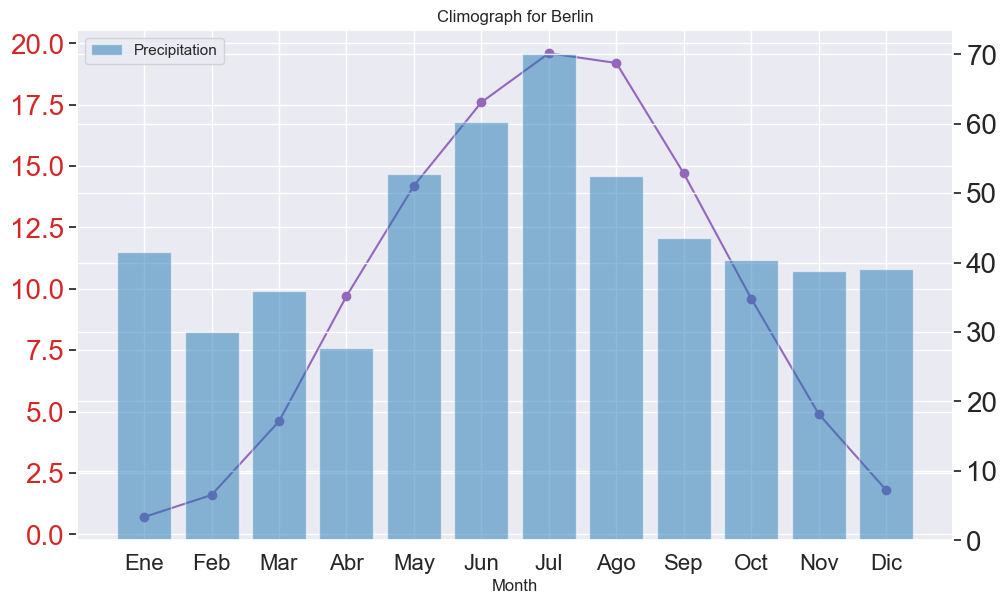

In [102]:
months = clima1.index
temperature_media = clima1['Temp. media (°C)']
precipitation = clima1['Precipitación total (mm)']

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel("Month")
ax1.plot(months, temperature_media, color="tab:purple", marker='o', label="Media Temp")
ax1.tick_params(axis="y", labelcolor="tab:red")

ax2 = ax1.twinx()
ax2.bar(months, precipitation, color="tab:blue", alpha=0.5, label="Precipitation")

fig.tight_layout()
plt.title("Climograph for Berlin")
plt.legend(loc="upper left")
plt.show()


In [156]:
clima1.to_csv('clima.csv')

In [114]:
BerlinNeigh

neighbourhood_group  count  average_price
0      Marzahn - Hellersdorf    106      79.818396
1              Reinickendorf    202      73.003094
2                    Spandau    207      55.943237
3      Steglitz - Zehlendorf    306      90.732435
4                Lichtenberg    345      89.331884
5         Treptow - Köpenick    524      91.262405
6     Tempelhof - Schöneberg    918     106.627451
7       Charlottenburg-Wilm.   1209     115.465674
8                   Neukölln   1555      77.524116
9                     Pankow   2058     111.743197
10                     Mitte   2833     131.090187
11  Friedrichshain-Kreuzberg   2871     104.628004

In [124]:
dflocations = pd.DataFrame(locations)
dflocations

0          1
0      52.534710  13.418100
1      52.532690  13.418050
2      52.548130  13.403660
3      52.545960  13.422910
4      52.537110  13.408880
...          ...        ...
13129  52.570278  13.313004
13130  52.575520  13.320740
13131  52.568030  13.359930
13132  52.566320  13.360350
13133  52.566801  13.361642

[13134 rows x 2 columns]

## Conversion to CSV of Various Dataframes for Use in PowerBI

In [125]:
dflocations.to_csv('locations.csv',index=False)

In [129]:
listings.to_csv('listings.csv')

In [133]:
propertyType = listings['property_type']
propertyType

id
3176                           Entire rental unit
9991                           Entire rental unit
14325                          Entire rental unit
30295                          Entire rental unit
20858                                 Entire loft
                                 ...             
958571350772689489             Entire rental unit
970997180714426992    Private room in rental unit
978143323297421141     Shared room in rental unit
978149609147190141     Shared room in rental unit
978123043897555466     Shared room in rental unit
Name: property_type, Length: 13134, dtype: object

In [135]:
propertyType = pd.DataFrame(propertyType)

In [139]:
propertyType.to_csv('propType.csv')

In [152]:
sum_available.to_csv('sum_available.csv')


In [158]:
average_price.to_csv('average_price.csv')

In [154]:
feq2.to_csv('pairsmean.csv')
